# Cosine Similarity Restarts

**Key idea:** The k-means algorithm often has some "restarts" encoded so that you can restart it several times (default 10 in scikit learn), and then choose the best result of the clustering algorithm.

In the `Cosine-similarity` notebook, I discovered that there was quite a bit of variance in the cosine similarity, even with keeping the (1) Same test batch size and (2) same model weights.

So my curiosity question is... if I keep the same setup, but just increase the number of query vectors that I sample, will I come to a better minimum?

**Key idea:** Choose the best samples based on the orthogonality of the query vectors. This ensures the queries focus on different parts of the input image :) 

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import SoftPositionalEmbed, build_grid
from torch.nn import init
from train import train

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cuda:0'

In [3]:
with open('code/configs/learn-init-warm2.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

hps

{'hidden_dim': 16,
 'k_slots': 3,
 'query_dim': 128,
 'softmax_T': 'default',
 'learn_init': True,
 'device': 'cuda:0'}

In [4]:
from itertools import combinations

def cosSimAllSlots(att,k_slots):
    '''
    Compute the cosine similarity over all 
    possible combinations of slots
    '''
    cs =  torch.cat([torch.nn.CosineSimilarity()(att[:,i],att[:,j])[None,:] 
                               for i,j in combinations(range(k_slots),2)], axis=0)
    return cs.sum(axis=0)
    

In [5]:
class SlotAttentionReInit(torch.nn.Module):
    def __init__(self, 
                 resolution=(32,32),
                 k_slots=3, 
                 num_conv_layers=3,
                 hidden_dim=32, 
                 final_cnn_relu=False,
                 learn_init=False,
                 query_dim=32, 
                 n_iter=2,
                 softmax_T='defaultx10',
                 pixel_mult=1,
                 pos_inpts=False,
                 device='cpu',
                 n_retarts=1
                 ):
        '''
        Slot attention encoder block with positional embedding

        Inputs:
        - resolution 
        - k_slots (default 3): number of slots (note, can vary between training and test time)
        - num_conv_layers: # of convolutional layers to apply (google paper has 4)
        - hidden_dim (default 32): The hidden dimension for the CNN (currently single layer w/ no non-linearities)
        - final_cnn_relu: Whether to apply the final cnn relu for these experiments (use true to mimic google repo)
        - query_dim (default 32): The latent space dimension that the slots and the queries get computed in
        - n_iter (default  2): Number of slot attention steps to apply (defualt 2)
        - T (str): Softmax temperature for scaling the logits 
            Needs to be one of 3 options:
            * default: 1/sqrt(query_dim)
            * defaultx10: 1/sqrt(query_dim)*10 (from LH WTFAE nb)
            * 1/D: 1/query_dim, as suggested by muTransfer 2203.03466
        - device (str): Which device to put the model on.
            Options: cpu (default), mps, cuda:{i}
            Also used when drawing random samples for the query points 
            and the grid generation for the positional encoding
        '''
        super().__init__()

        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.n_iter = n_iter
        self.n_retarts = n_retarts
        
        self.resolution = resolution

        self.device=device
        
        assert softmax_T in ['default','defaultx10','1/D'] 
        if softmax_T=='default':
            self.softmax_T = 1/np.sqrt(query_dim)
        elif softmax_T=='defaultx10':
            self.softmax_T = 10/np.sqrt(query_dim)
        elif softmax_T=='1/D':
            self.softmax_T = 1/query_dim
        else:
            print(f'Softmax temperature {T} not supported')
            raise SyntaxError
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        input_dim = 5 if pos_inpts else 1 # whether or not to include the pixels w/ the input
        
        kwargs = { 'out_channels': hidden_dim,'kernel_size': 5, 'padding':2 }

        cnn_layers = [torch.nn.Conv2d(input_dim,**kwargs)]
        for i in range(num_conv_layers-1):
            cnn_layers += [torch.nn.ReLU(), torch.nn.Conv2d(hidden_dim,**kwargs)] 
            
        if final_cnn_relu:
            '''
            22.08.2023 Silly mistake, I didn't include a ReLU() after the last CNN filter 
            for first exps. This `final_cnn_relu` flag is a hack for bkwds compatibility.
            '''
            cnn_layers.append(torch.nn.ReLU())

        self.CNN_encoder = torch.nn.Sequential(*cnn_layers)
          
        self.posEnc = SoftPositionalEmbed(hidden_dim, resolution,device, pixel_mult)
        
        if pos_inpts:
            self.process_data = lambda X: \
                torch.cat([X,
                torch.tile(self.posEnc.grid.permute(0,3,1,2), [X.shape[0],1,1,1])],dim=1)
        else:
            self.process_data = lambda X: X

        self.init_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim,hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim,hidden_dim)
        )


        if learn_init:
            self.slots_mu = torch.nn.Parameter(torch.randn(1, 1, self.query_dim))
            self.slots_logsigma = torch.nn.Parameter(torch.zeros(1, 1, self.query_dim))
            init.xavier_uniform_(self.slots_logsigma)

            self.init_slots = self.SA_init_slots

        else:
            self.init_slots = self.LH_init_slots

    def SA_init_slots(self,Nbatch):
        '''
        Slot init taken from
        https://github.com/lucidrains/slot-attention/blob/master/slot_attention/slot_attention.py
        '''
        mu = self.slots_mu.expand(Nbatch, self.k_slots, -1)
        sigma = self.slots_logsigma.exp().expand(Nbatch, self.k_slots, -1)

        return mu + sigma * torch.randn(mu.shape).to(self.device)

    def LH_init_slots(self, Nbatch):
        noise = torch.randn(Nbatch, self.k_slots, self.query_dim).to(self.device)
        
        mu = torch.zeros(1,1,self.query_dim).to(self.device)
        logsigma = torch.zeros(1,1,self.query_dim).to(self.device)
        
        return mu + noise*logsigma.exp()
    
    def encoder(self,data):

        # If pos_inpts was passed at initialization, concatenate the grid
        encoded_data = self.process_data(data)

        # Apply the CNN encoder
        encoded_data = self.CNN_encoder(encoded_data)
        
        # Put the channel dim at the end
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) 
                 
        # Add the positional embeddings
        encoded_data = self.posEnc(encoded_data)
        
        # Flatten the pixel dims and apply the data normalization + MLP
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = self.dataN(encoded_data)
        encoded_data = self.init_mlp(encoded_data)
        
        return encoded_data
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients.append( grad )
    
    def attention_and_weights(self,queries,encoded_data):
        keys = self.toK(encoded_data)
        logits = torch.einsum('bse,bde->bsd',queries,keys) * self.softmax_T
        
        att = torch.nn.functional.softmax(logits, dim = 1) 

        if att.requires_grad:
            h = logits.register_hook(self.activations_hook)
        
        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def iterate(self, queries, encoded_data):
        
        # queries: (bs, k_slots, query_dim)
        # att, wts: (bs, k_slots, img_dim)
        att,wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
        
        vals = self.toV(encoded_data) # bs, img_dim, query_dim
        updates = torch.einsum('bsd,bde->bse',wts,vals) # bs, n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )

        return updates.reshape(queries.shape)
        
    def single_init(self, encoded_data):

        # This is fine, I'll just save the gradients from the last step of the initialization
        self.gradients = []
    
        # Initialize the queries
        Nbatch = encoded_data.shape[0]
        queries = self.init_slots(Nbatch) # Shape (Nbatch, k_slots, query_dim)
        
        for i in range(self.n_iter):
            queries = self.iterate(queries, encoded_data)    
            
        # Then with the _final_ query vector, calc what the attn + weights would be
        att, wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
            
        return queries, att
    
    def forward(self, data):
        
        bs = data.shape[0]
        encoded_data = self.encoder(data)
        
        queries_s = []
        att_s     = []
        cs_all_s  = []
        
        for seed in range(self.n_retarts):
        
            # Get the queries
            queries, att = self.single_init(encoded_data)
    
            queries_s.append(queries)
            att_s.append(att)
            with torch.no_grad():
                cs_all_s.append(cosSimAllSlots(att,self.k_slots))
        
        with torch.no_grad():
            # Return the query vector that minimizes the cosine similarity
            cs_all_s = torch.cat([csi[None,:] for csi in cs_all_s],axis=0)
            vals2, idx2 = torch.min(cs_all_s,dim=0)
                
        queries_s = torch.cat([qi[None,:] for qi in queries_s],axis=0)
        att_s = torch.cat([ai[None,:] for ai in att_s],axis=0)
                
        queries_final = torch.permute(queries_s,(1,0,2,3))[np.arange(bs),idx2]
        att_final = torch.permute(att_s,(1,0,2,3))[np.arange(bs),idx2]

        # Returning None b/c I was never using the weights at the end of this anyways
        return queries_final, att_final, None

In [6]:
hps['device'] = device

In [7]:
m = SlotAttentionReInit(n_retarts=10,**hps).to(device)

weightPath = 'code/models/learn-init-warm/m_44000.pt'
m.load_state_dict(torch.load(weightPath,map_location=device))


<All keys matched successfully>

In [8]:
cID = 'li-warm-restart-10x-gpu'
modelDir = f'code/models/{cID}'
figDir = f'code/figures/{cID}'

for d in [modelDir,figDir]:
    os.mkdir(d)

In [9]:
opt = cd['opt']
opt['Ntrain'] = 40_000

kwargs = cd['data']

In [10]:
opt

{'lr': 0.000275, 'Ntrain': 40000, 'bs': 256}

In [11]:
device

'cuda:0'

Training model with 3 slots on 2rings


/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/data.py:97: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 0 , loss 0.017814802 , lr 0.0


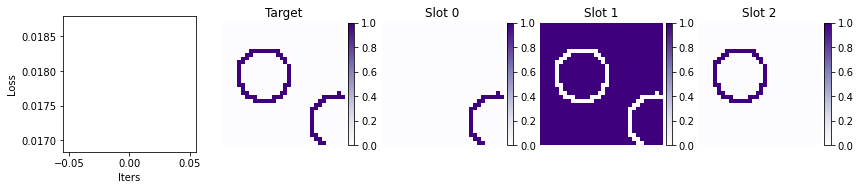

iter 25 , loss 0.018552937 , lr 1.374523543881688e-06


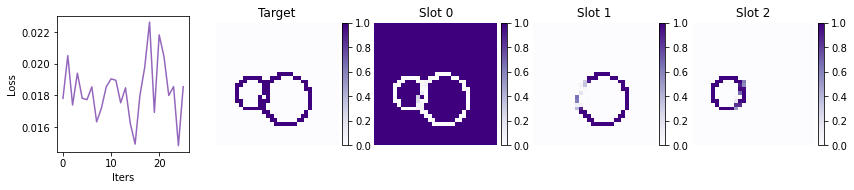

iter 50 , loss 0.017013876 , lr 2.748094505723744e-06


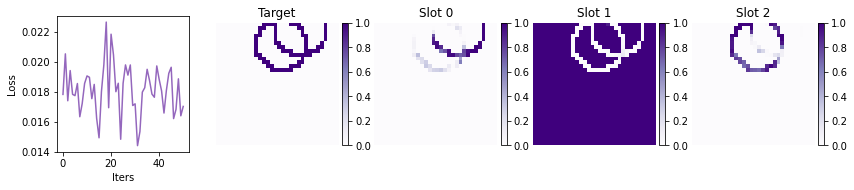

iter 75 , loss 0.019473419 , lr 4.120713380650033e-06


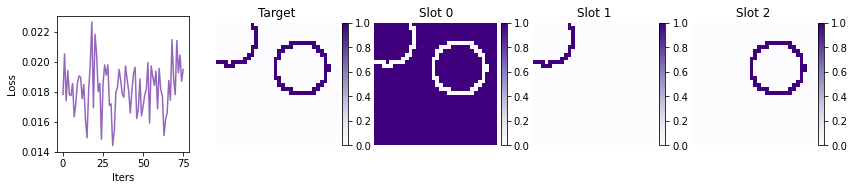

iter 100 , loss 0.017338939 , lr 5.4923806635556595e-06


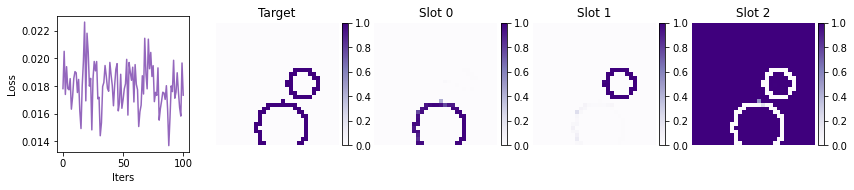

iter 125 , loss 0.019576095 , lr 6.863096849107075e-06


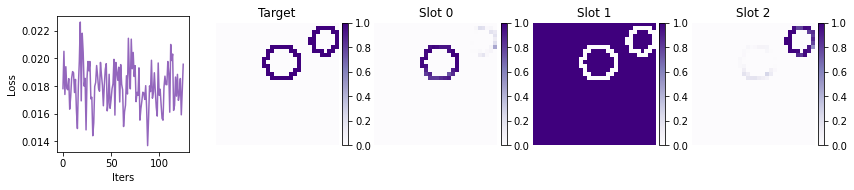

iter 150 , loss 0.017042466 , lr 8.232862431742168e-06


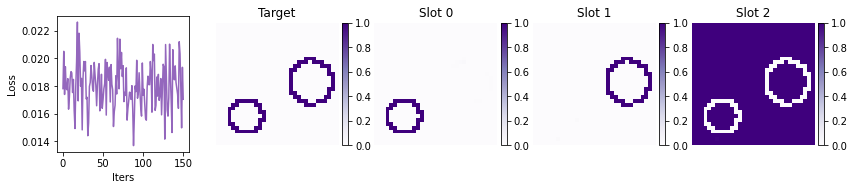

iter 175 , loss 0.01787108 , lr 9.601677905670375e-06


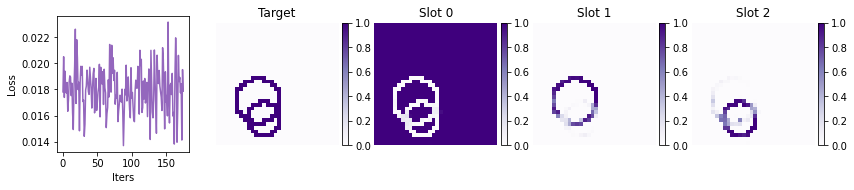

iter 200 , loss 0.017706065 , lr 1.0969543764872765e-05


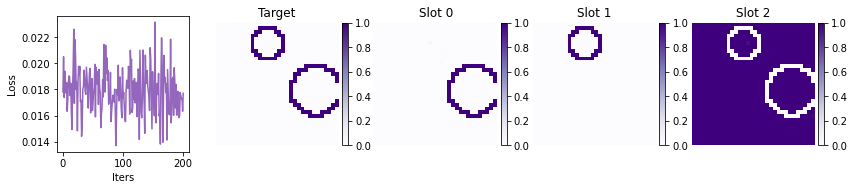

iter 225 , loss 0.019928189 , lr 1.233646050310215e-05


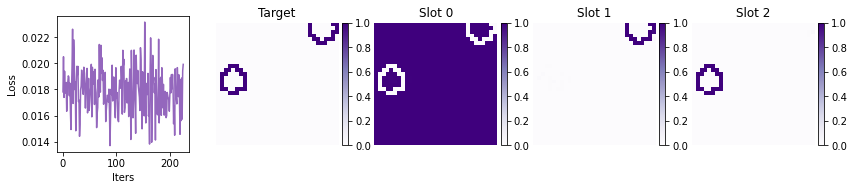

iter 250 , loss 0.018214539 , lr 1.3702428613883184e-05


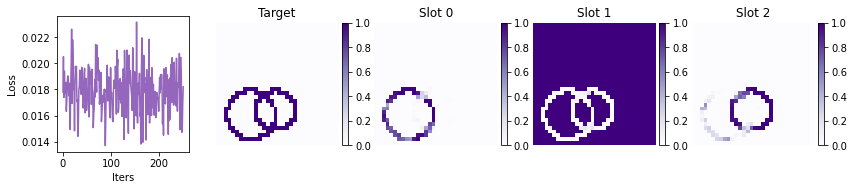

iter 275 , loss 0.017001044 , lr 1.5067448590512447e-05


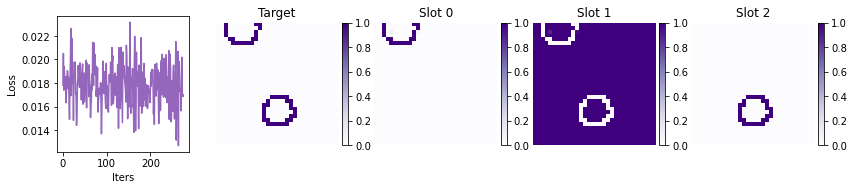

iter 300 , loss 0.019530524 , lr 1.6431520926058558e-05


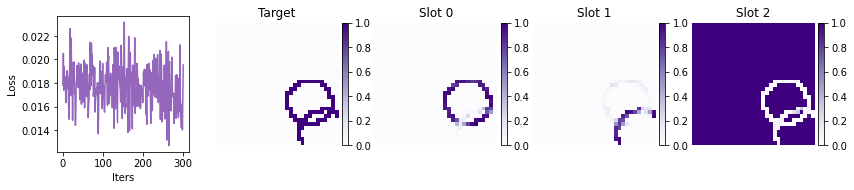

iter 325 , loss 0.01617223 , lr 1.779464611336228e-05


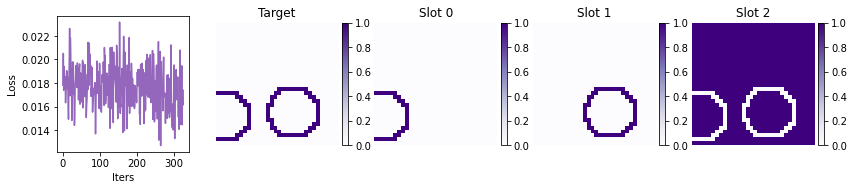

iter 350 , loss 0.017631643 , lr 1.91568246450366e-05


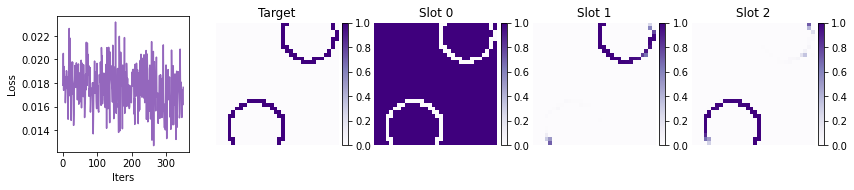

iter 375 , loss 0.015809052 , lr 2.0518057013466826e-05


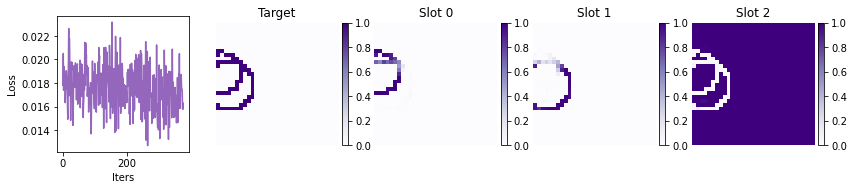

iter 400 , loss 0.016080443 , lr 2.1878343710810718e-05


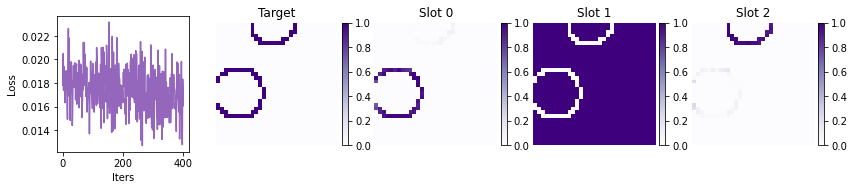

iter 425 , loss 0.015593262 , lr 2.3237685228998554e-05


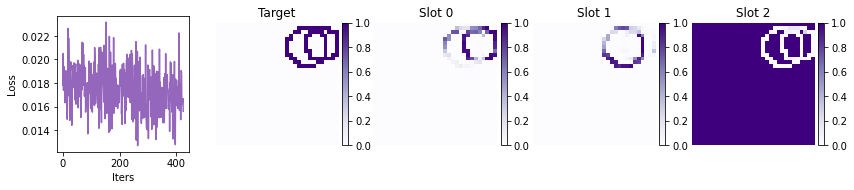

iter 450 , loss 0.01612245 , lr 2.459608205973323e-05


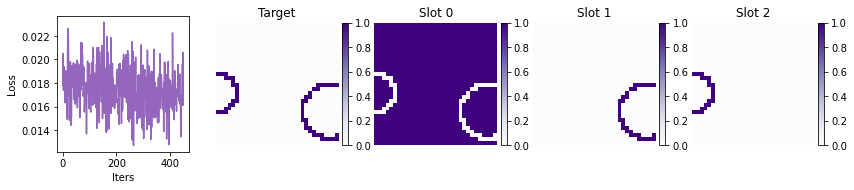

iter 475 , loss 0.02039058 , lr 2.5953534694490392e-05


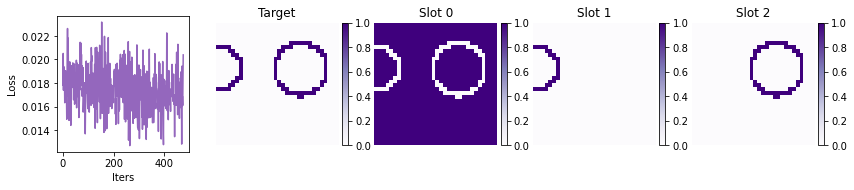

iter 500 , loss 0.015510853 , lr 2.7310043624518492e-05


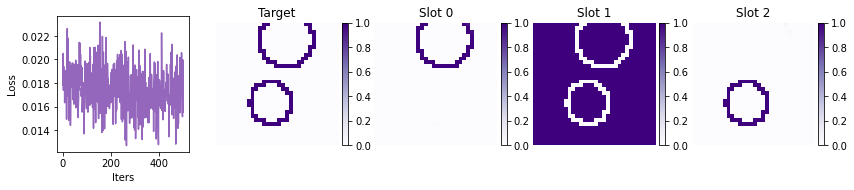

iter 525 , loss 0.017872225 , lr 2.8665609340838892e-05


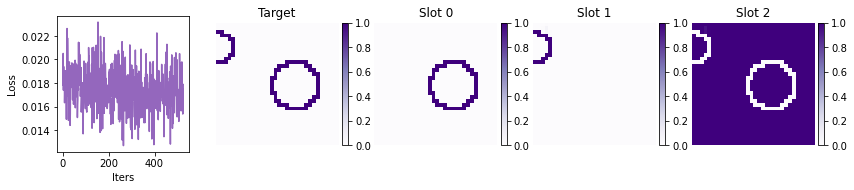

iter 550 , loss 0.016221525 , lr 3.0020232334246013e-05


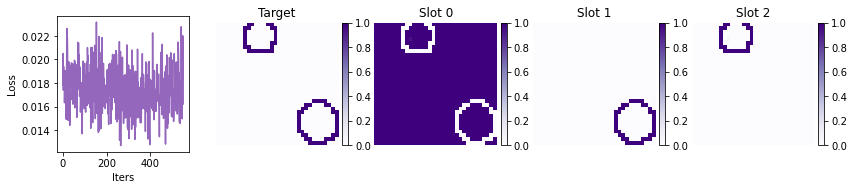

iter 575 , loss 0.017167715 , lr 3.1373913095307365e-05


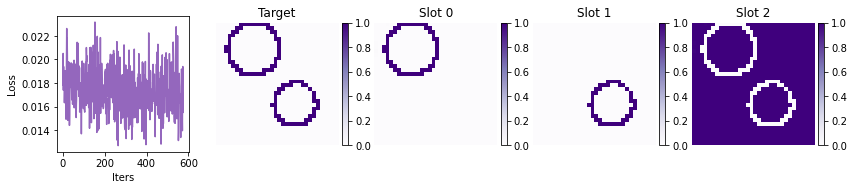

iter 600 , loss 0.013644347 , lr 3.272665211436367e-05


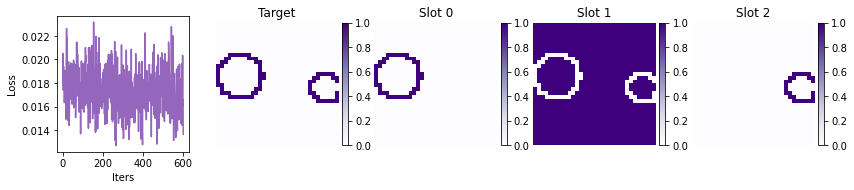

iter 625 , loss 0.015382405 , lr 3.407844988152901e-05


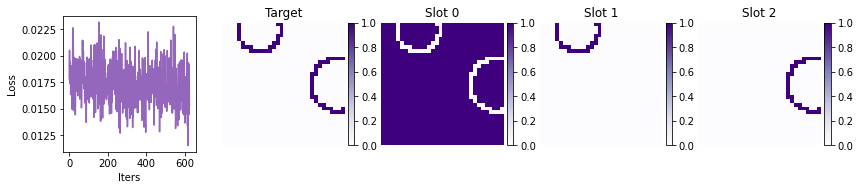

iter 650 , loss 0.013408583 , lr 3.542930688669083e-05


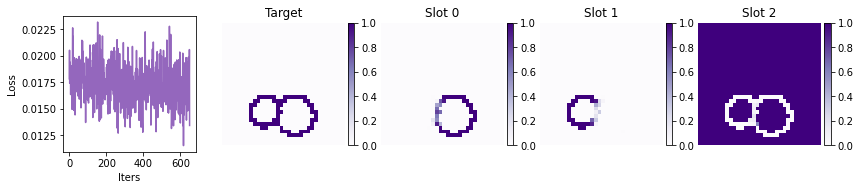

iter 675 , loss 0.015258791 , lr 3.677922361951012e-05


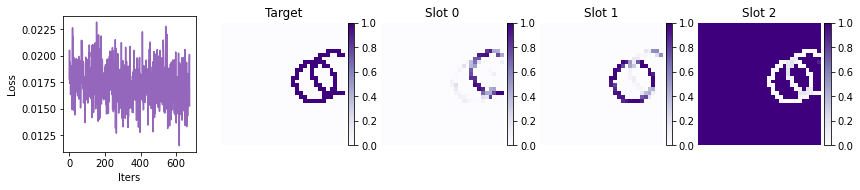

iter 700 , loss 0.012215993 , lr 3.8128200569421455e-05


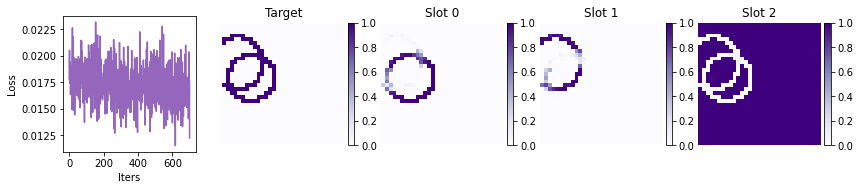

iter 725 , loss 0.017896663 , lr 3.9476238225633135e-05


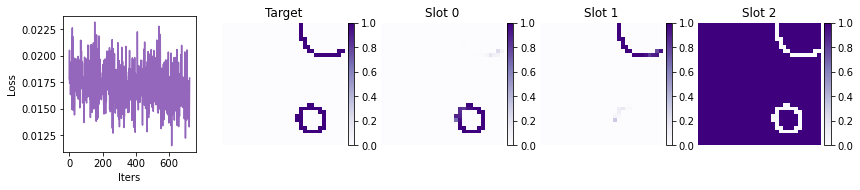

iter 750 , loss 0.014502486 , lr 4.0823337077127283e-05


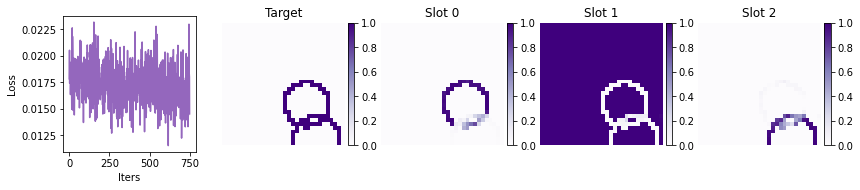

iter 775 , loss 0.018704873 , lr 4.21694976126599e-05


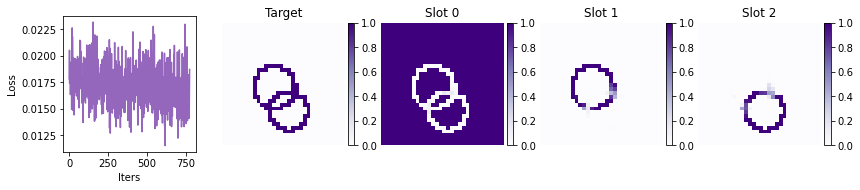

iter 800 , loss 0.018686084 , lr 4.351472032076099e-05


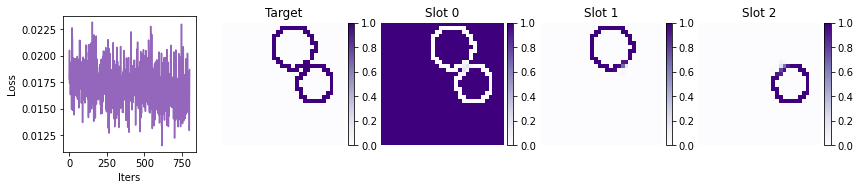

iter 825 , loss 0.01783003 , lr 4.485900568973467e-05


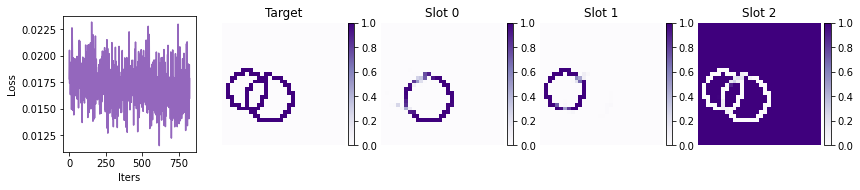

iter 850 , loss 0.01444622 , lr 4.620235420765926e-05


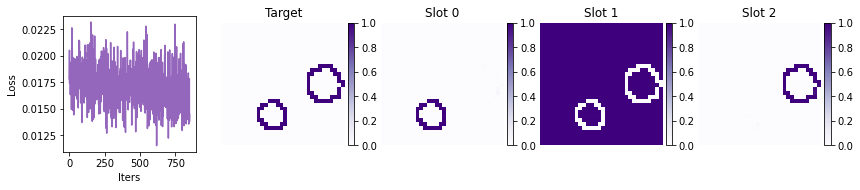

iter 875 , loss 0.017885227 , lr 4.754476636238734e-05


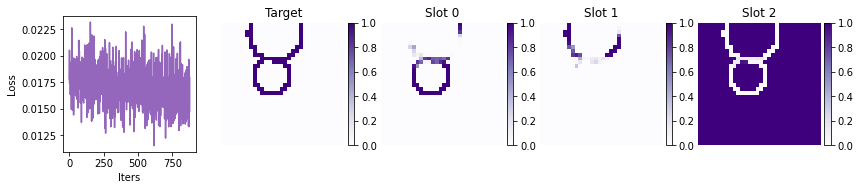

iter 900 , loss 0.01518264 , lr 4.8886242641545934e-05


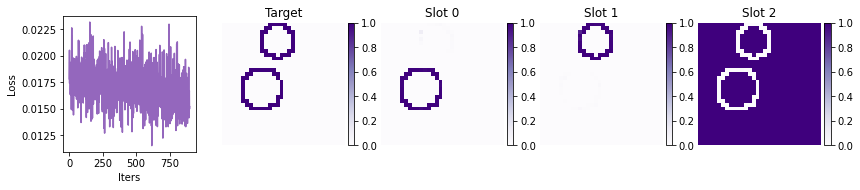

iter 925 , loss 0.017045159 , lr 5.022678353253655e-05


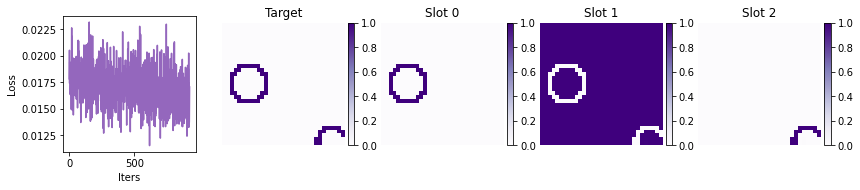

iter 950 , loss 0.016866773 , lr 5.1566389522535247e-05


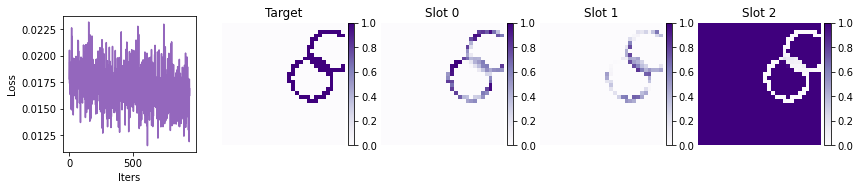

iter 975 , loss 0.01628758 , lr 5.29050610984928e-05


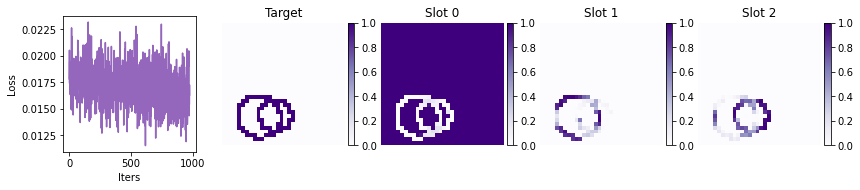

iter 1000 , loss 0.019050384 , lr 5.424279874713476e-05


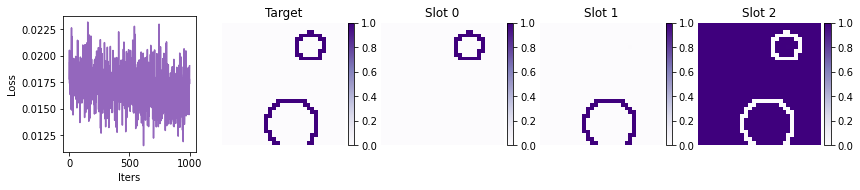

iter 1025 , loss 0.017577669 , lr 5.557960295496157e-05


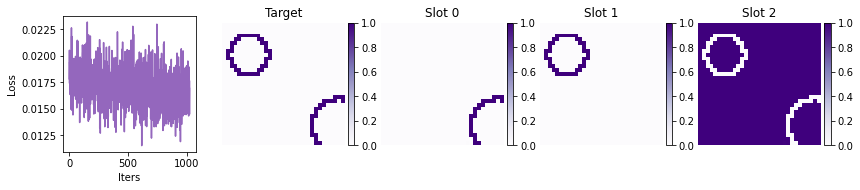

iter 1050 , loss 0.017988613 , lr 5.6915474208248664e-05


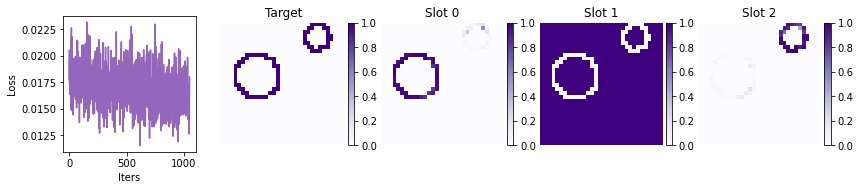

iter 1075 , loss 0.017689072 , lr 5.825041299304652e-05


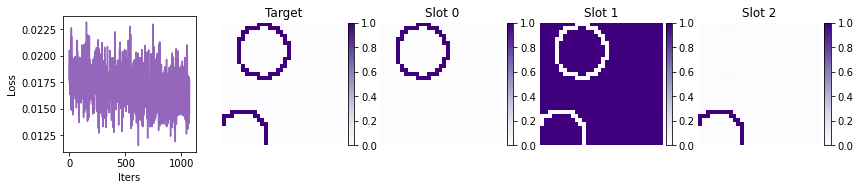

iter 1100 , loss 0.014845834 , lr 5.958441979518081e-05


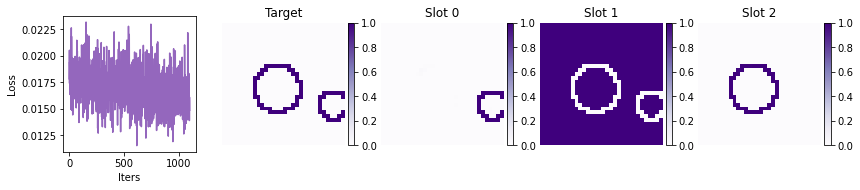

iter 1125 , loss 0.013989337 , lr 6.0917495100252496e-05


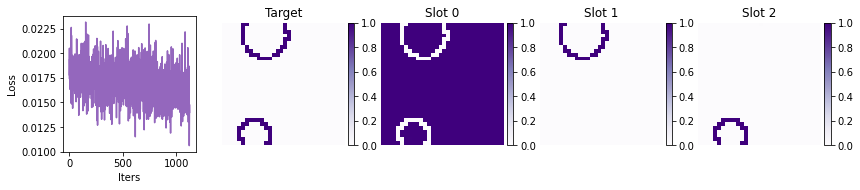

iter 1150 , loss 0.021100424 , lr 6.224963939363787e-05


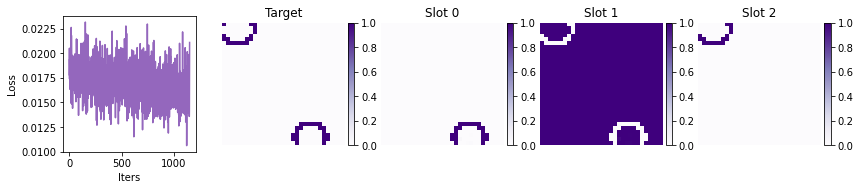

iter 1175 , loss 0.012790322 , lr 6.358085316048872e-05


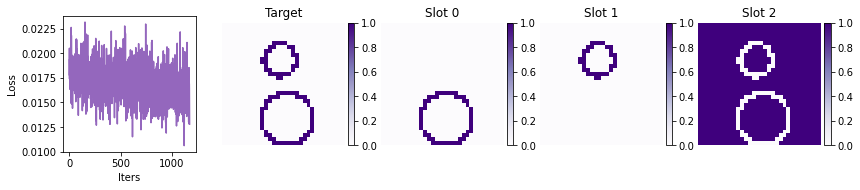

iter 1200 , loss 0.014645634 , lr 6.491113688573239e-05


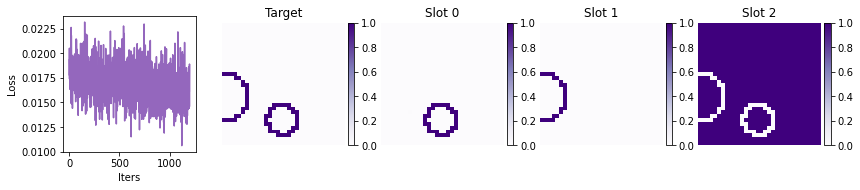

iter 1225 , loss 0.019006774 , lr 6.62404910540719e-05


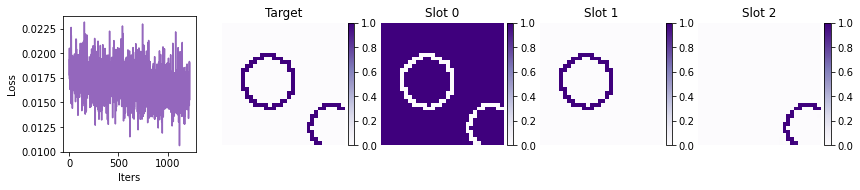

iter 1250 , loss 0.015247342 , lr 6.756891614998601e-05


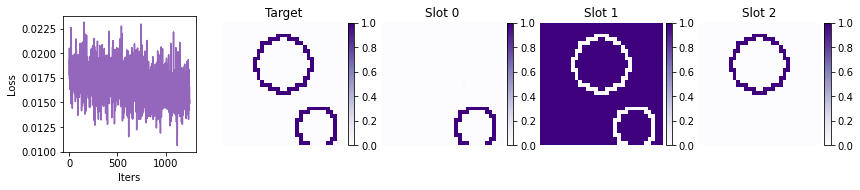

iter 1275 , loss 0.017211117 , lr 6.889641265772934e-05


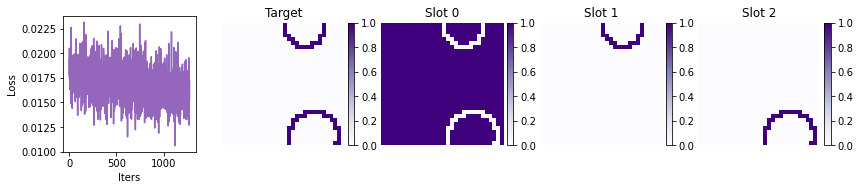

iter 1300 , loss 0.0153563805 , lr 7.02229810613325e-05


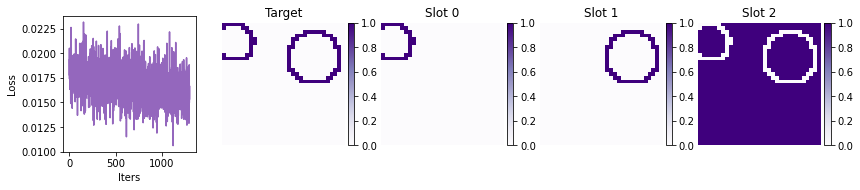

iter 1325 , loss 0.015180385 , lr 7.154862184460207e-05


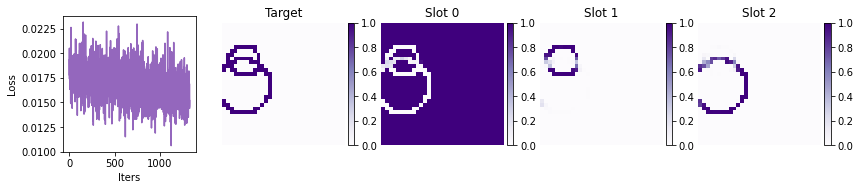

iter 1350 , loss 0.018698264 , lr 7.287333549112085e-05


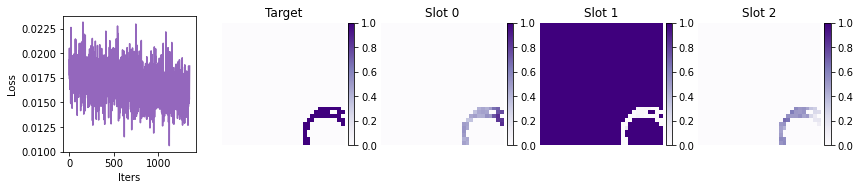

iter 1375 , loss 0.017910423 , lr 7.419712248424786e-05


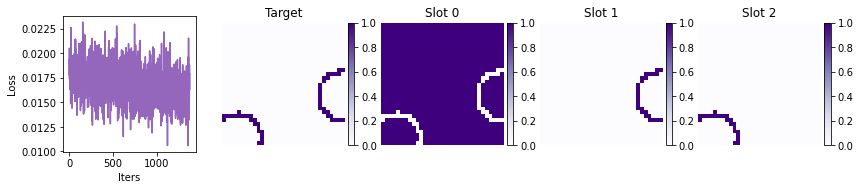

iter 1400 , loss 0.014434984 , lr 7.551998330711846e-05


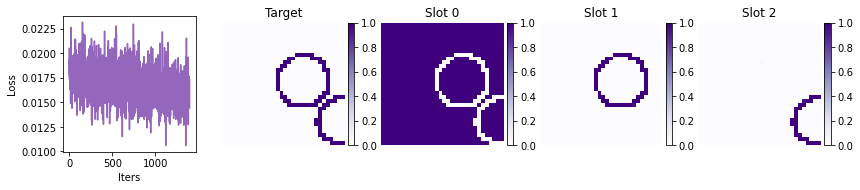

iter 1425 , loss 0.016293366 , lr 7.684191844264444e-05


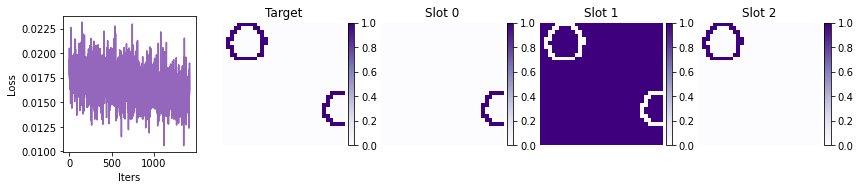

iter 1450 , loss 0.017372765 , lr 7.816292837351419e-05


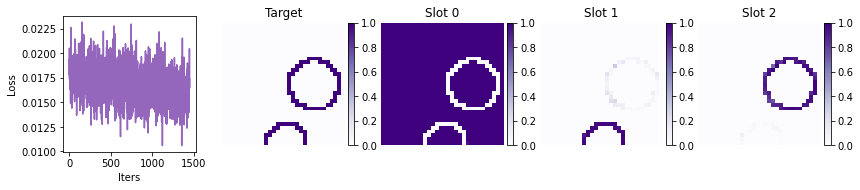

iter 1475 , loss 0.016617492 , lr 7.94830135821926e-05


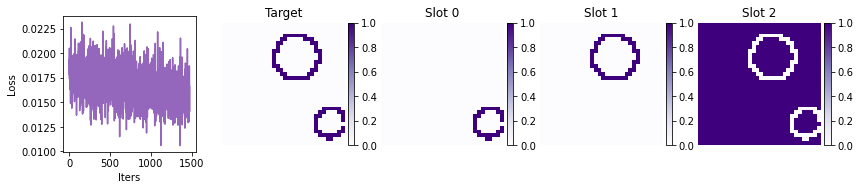

iter 1500 , loss 0.0175842 , lr 8.080217455092148e-05


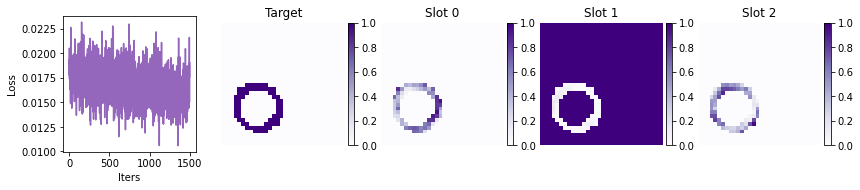

iter 1525 , loss 0.017649809 , lr 8.212041176171924e-05


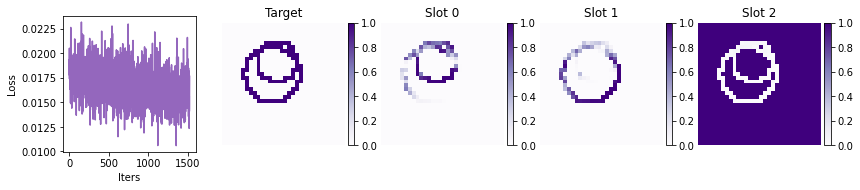

iter 1550 , loss 0.014751252 , lr 8.34377256963814e-05


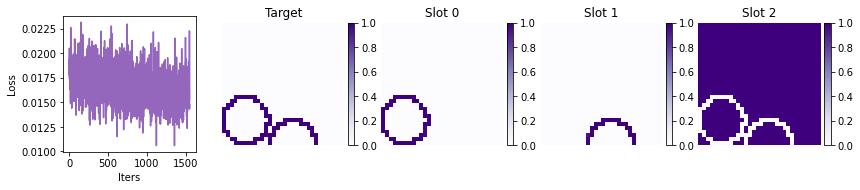

iter 1575 , loss 0.018055992 , lr 8.475411683648041e-05


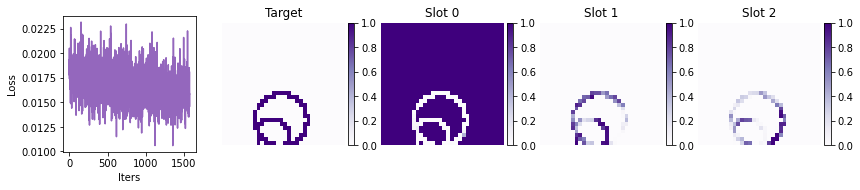

iter 1600 , loss 0.01654266 , lr 8.606958566336587e-05


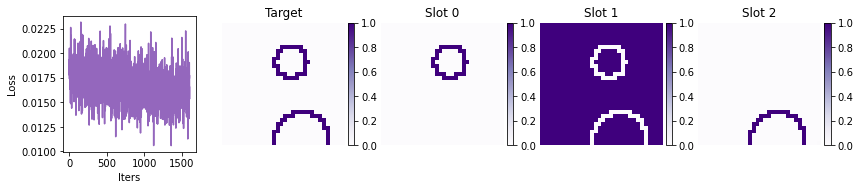

iter 1625 , loss 0.013848472 , lr 8.738413265816457e-05


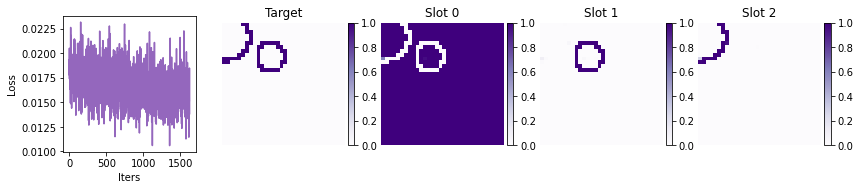

iter 1650 , loss 0.016691139 , lr 8.869775830178059e-05


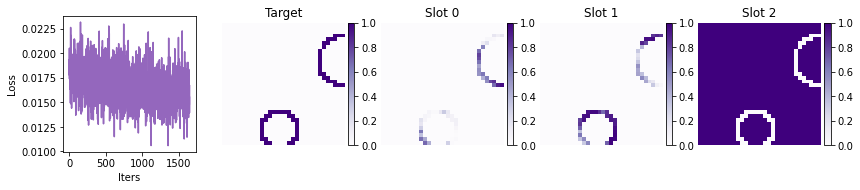

iter 1675 , loss 0.013344504 , lr 9.00104630748955e-05


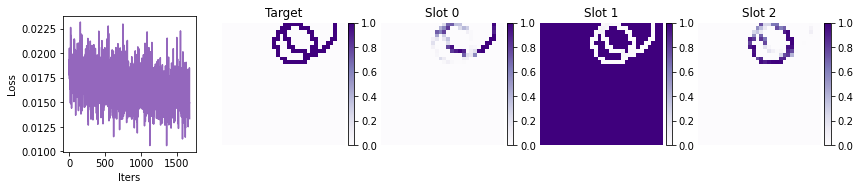

iter 1700 , loss 0.0130203795 , lr 9.132224745796826e-05


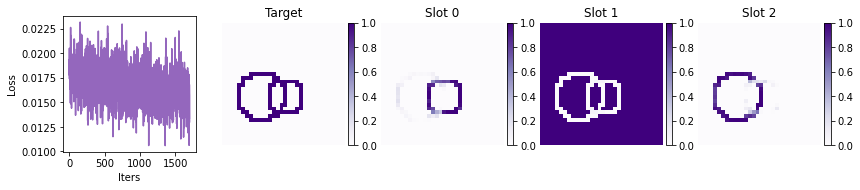

iter 1725 , loss 0.01426406 , lr 9.263311193123554e-05


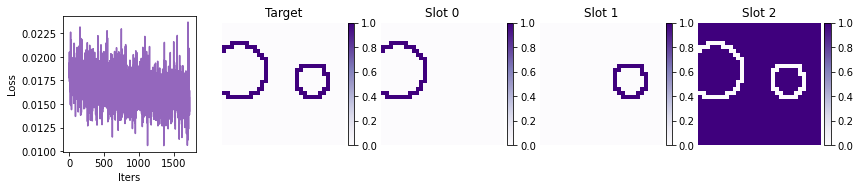

iter 1750 , loss 0.0120626 , lr 9.394305697471163e-05


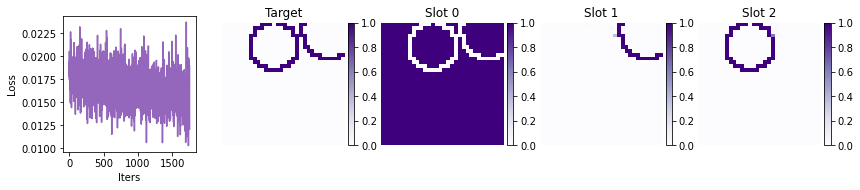

iter 1775 , loss 0.014383037 , lr 9.525208306818864e-05


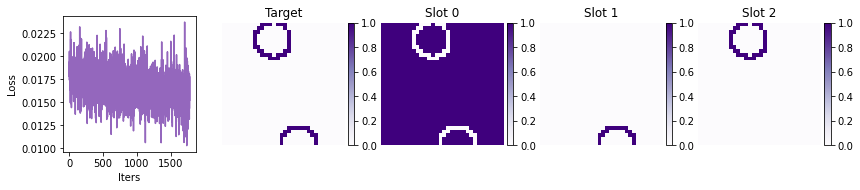

iter 1800 , loss 0.016862296 , lr 9.656019069123655e-05


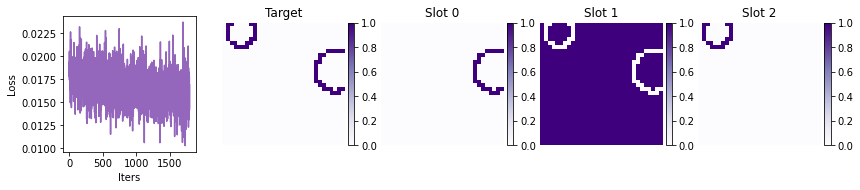

iter 1825 , loss 0.013882406 , lr 9.786738032320334e-05


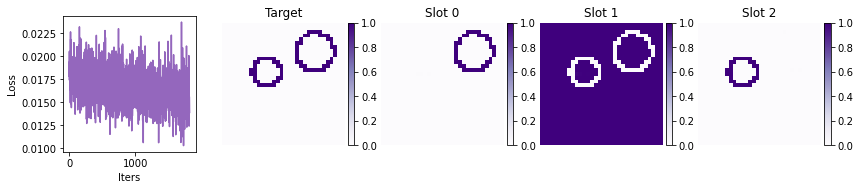

iter 1850 , loss 0.015454715 , lr 9.91736524432151e-05


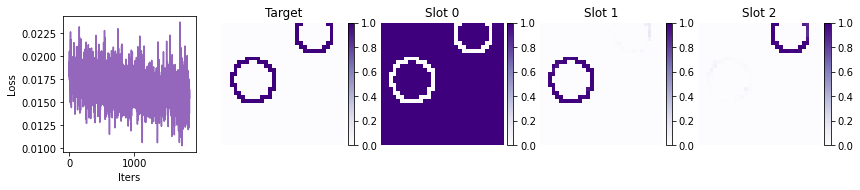

iter 1875 , loss 0.016910937 , lr 0.00010047900753017605


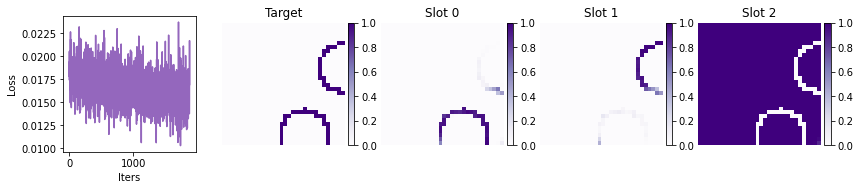

iter 1900 , loss 0.016341953 , lr 0.00010178344606276868


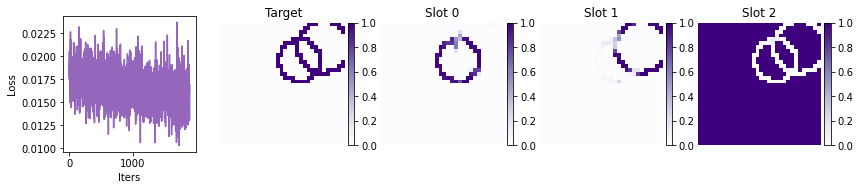

iter 1925 , loss 0.017824491 , lr 0.00010308696851945392


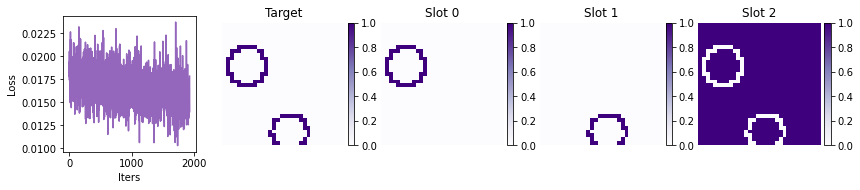

iter 1950 , loss 0.015725525 , lr 0.00010438957537847106


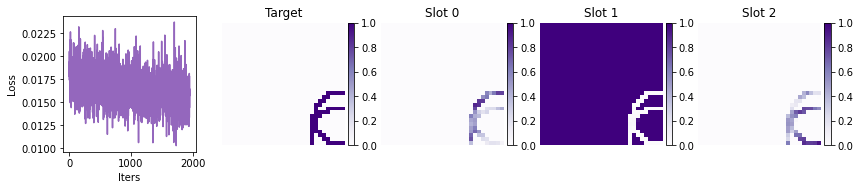

iter 1975 , loss 0.014986719 , lr 0.00010569126711783804


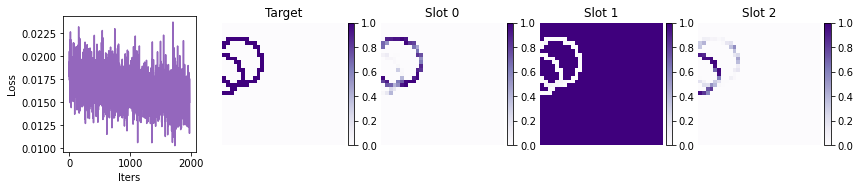

iter 2000 , loss 0.013877926 , lr 0.00010699204421535141


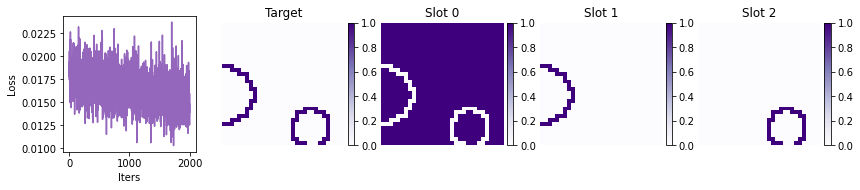

iter 2025 , loss 0.017780181 , lr 0.00010829190714858651


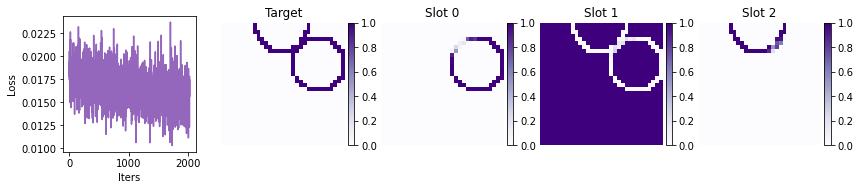

iter 2050 , loss 0.012712446 , lr 0.0001095908563948975


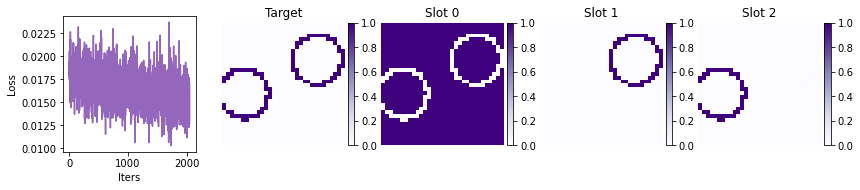

iter 2075 , loss 0.014748324 , lr 0.0001108888924314175


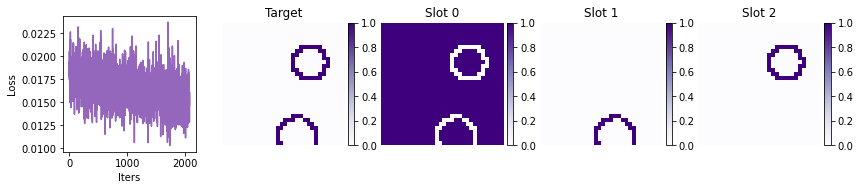

iter 2100 , loss 0.014406884 , lr 0.00011218601573505864


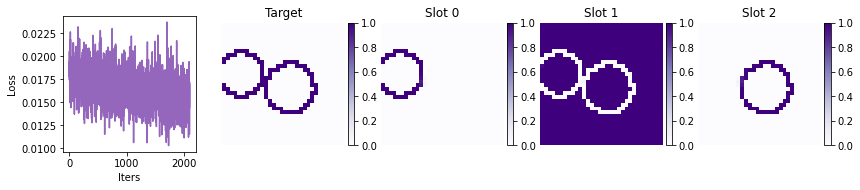

iter 2125 , loss 0.016255518 , lr 0.00011348222678251227


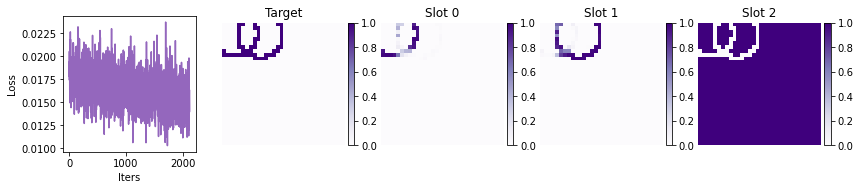

iter 2150 , loss 0.013375914 , lr 0.00011477752605024888


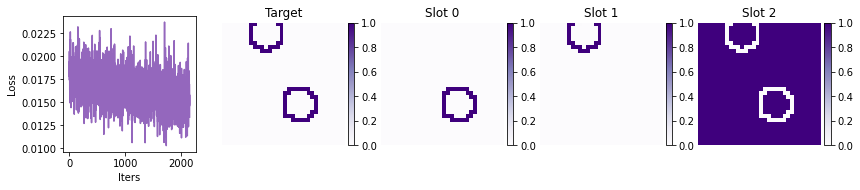

iter 2175 , loss 0.0155808255 , lr 0.00011607191401451834


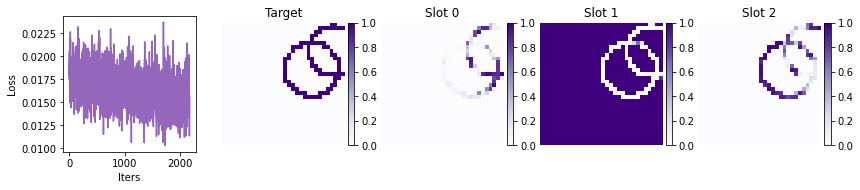

iter 2200 , loss 0.016053338 , lr 0.00011736539115134992


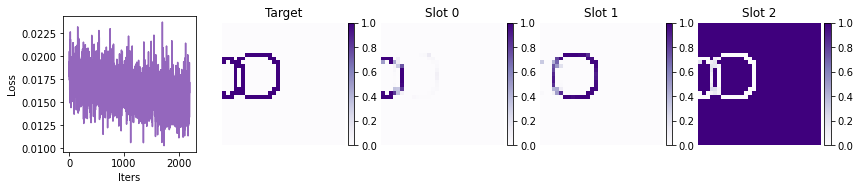

iter 2225 , loss 0.014393698 , lr 0.00011865795793655243


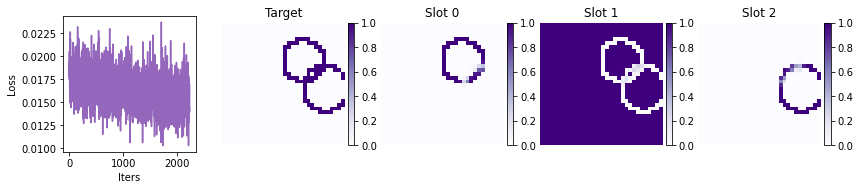

iter 2250 , loss 0.019185215 , lr 0.0001199496148457143


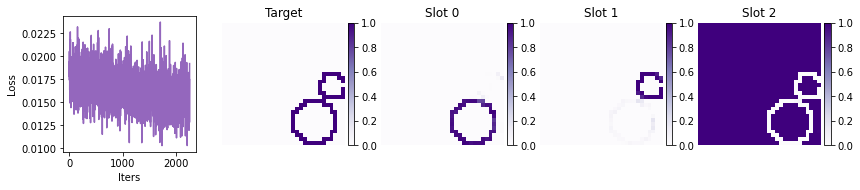

iter 2275 , loss 0.015887806 , lr 0.00012124036235420363


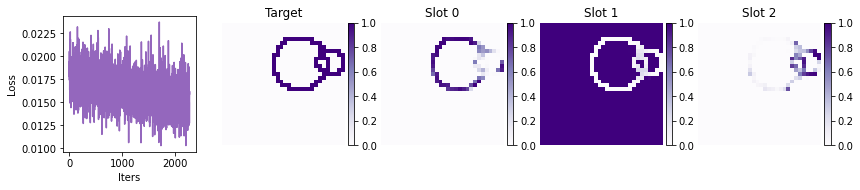

iter 2300 , loss 0.012758145 , lr 0.00012253020093716841


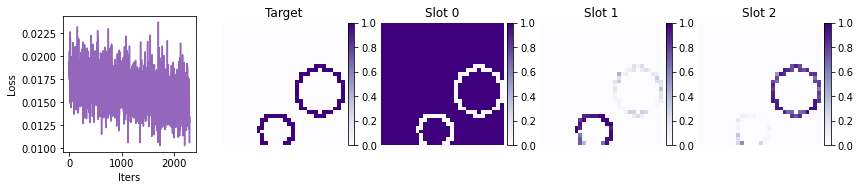

iter 2325 , loss 0.013700215 , lr 0.00012381913106953644


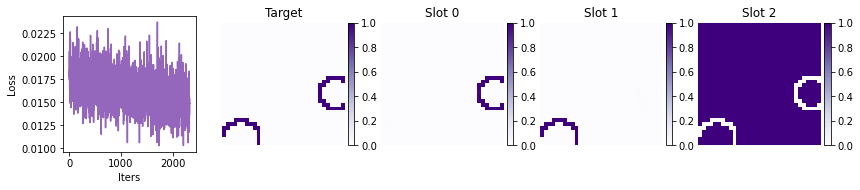

iter 2350 , loss 0.01527573 , lr 0.00012510715322601554


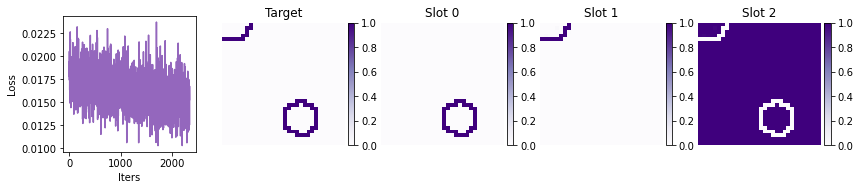

iter 2375 , loss 0.011947249 , lr 0.00012639426788109371


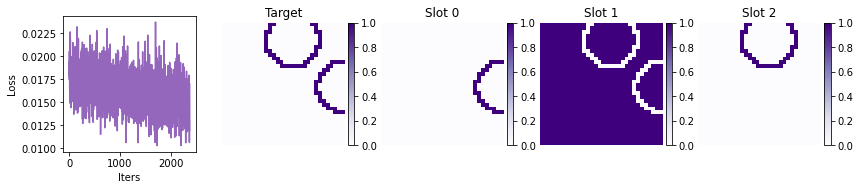

iter 2400 , loss 0.013107065 , lr 0.00012768047550903904


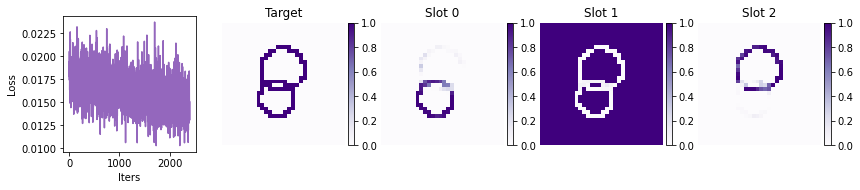

iter 2425 , loss 0.016082529 , lr 0.00012896577658389992


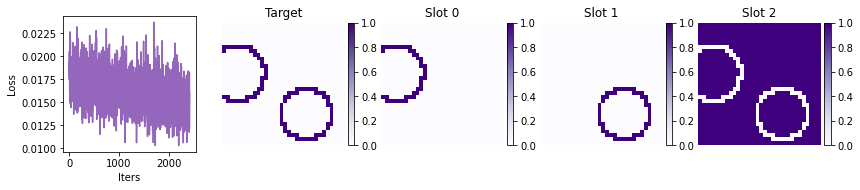

iter 2450 , loss 0.01674917 , lr 0.00013025017157950513


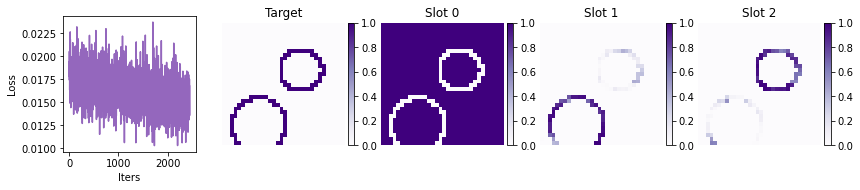

iter 2475 , loss 0.015729215 , lr 0.00013153366096946398


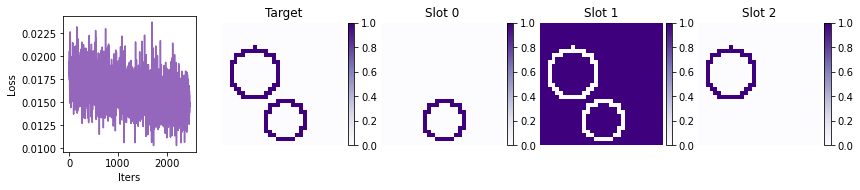

iter 2500 , loss 0.014132526 , lr 0.00013281624522716627


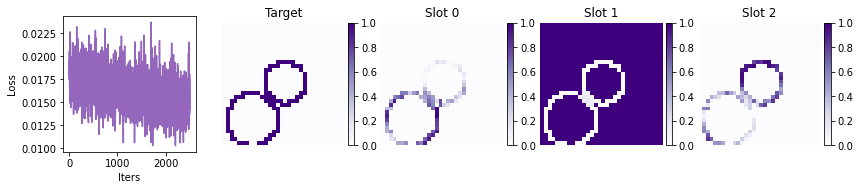

iter 2525 , loss 0.0151229035 , lr 0.0001340979248257825


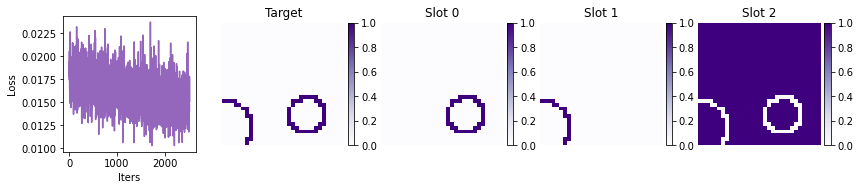

iter 2550 , loss 0.014895639 , lr 0.00013537870023826393


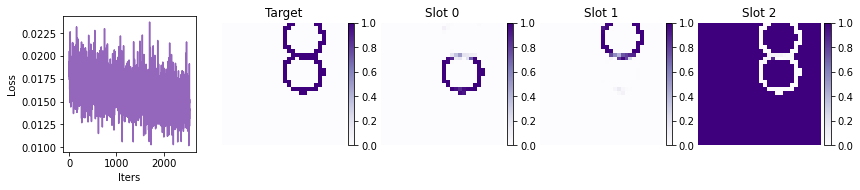

iter 2575 , loss 0.016948486 , lr 0.00013665857193734268


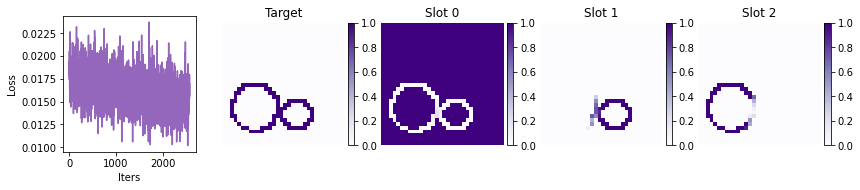

iter 2600 , loss 0.016106375 , lr 0.0001379375403955318


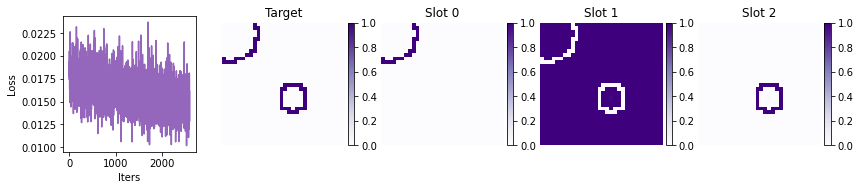

iter 2625 , loss 0.013259734 , lr 0.0001392156060851254


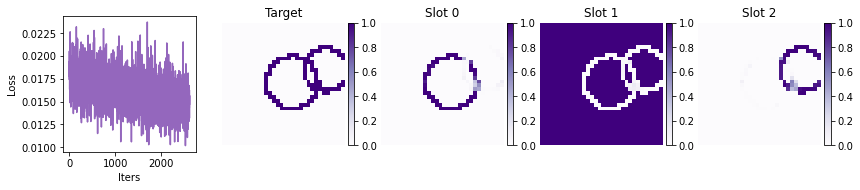

iter 2650 , loss 0.013776448 , lr 0.00014049276947819875


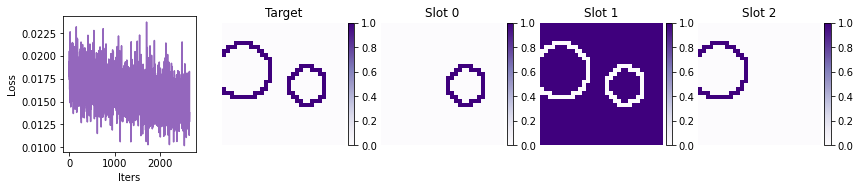

iter 2675 , loss 0.012743722 , lr 0.00014176903104660835


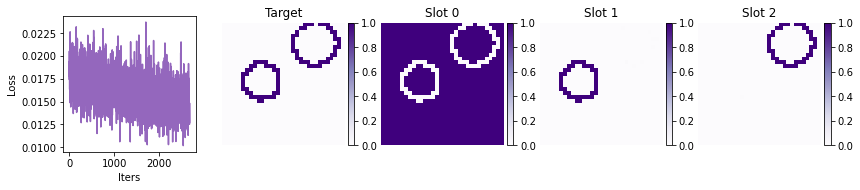

iter 2700 , loss 0.015015956 , lr 0.00014304439126199198


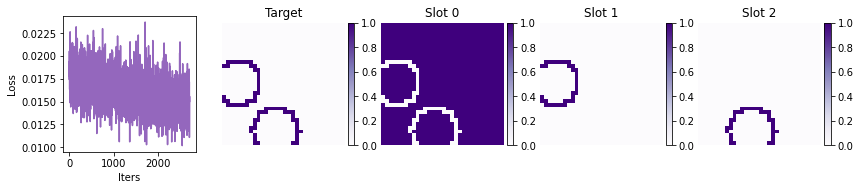

iter 2725 , loss 0.015399856 , lr 0.00014431885059576892


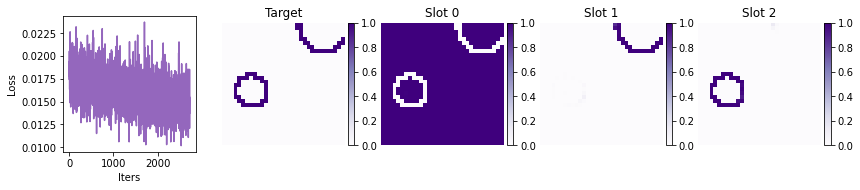

iter 2750 , loss 0.01596114 , lr 0.0001455924095191399


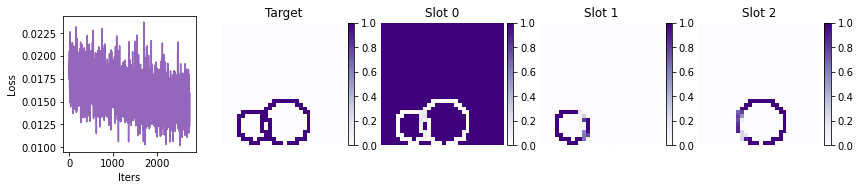

iter 2775 , loss 0.014836958 , lr 0.00014686506850308736


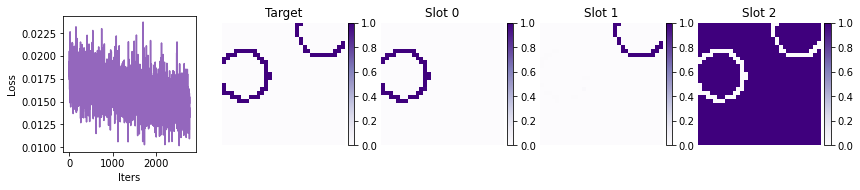

iter 2800 , loss 0.015051942 , lr 0.00014813682801837532


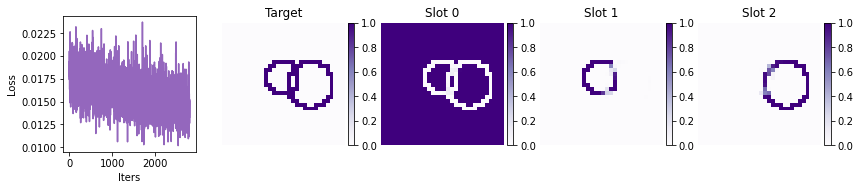

iter 2825 , loss 0.0135065615 , lr 0.0001494076885355497


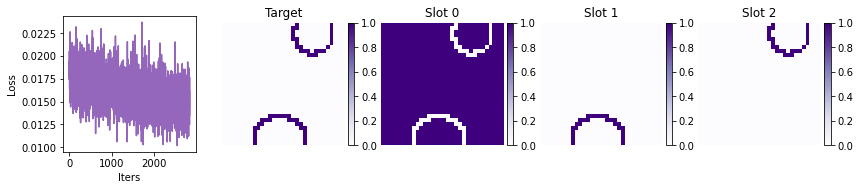

iter 2850 , loss 0.014335797 , lr 0.00015067765052493835


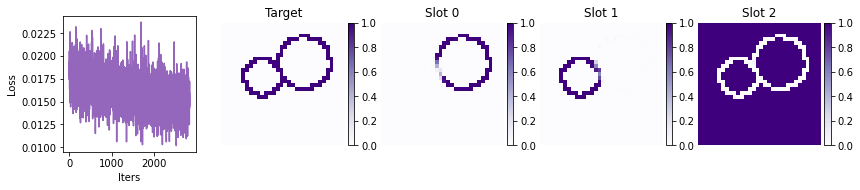

iter 2875 , loss 0.01425749 , lr 0.00015194671445665098


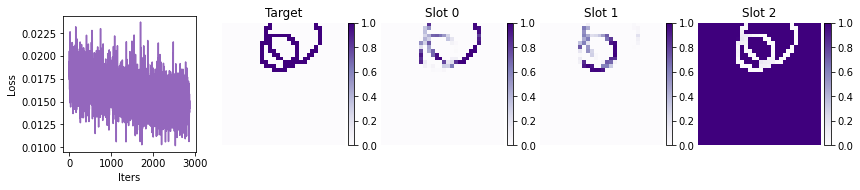

iter 2900 , loss 0.0131325815 , lr 0.0001532148808005795


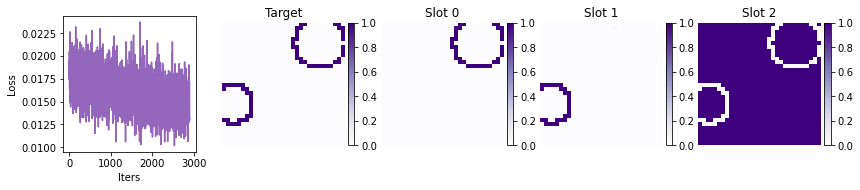

iter 2925 , loss 0.015832596 , lr 0.00015448215002639805


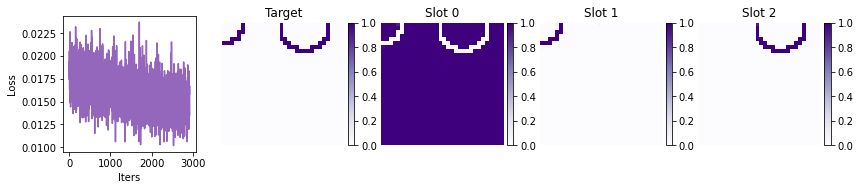

iter 2950 , loss 0.013232017 , lr 0.00015574852260356281


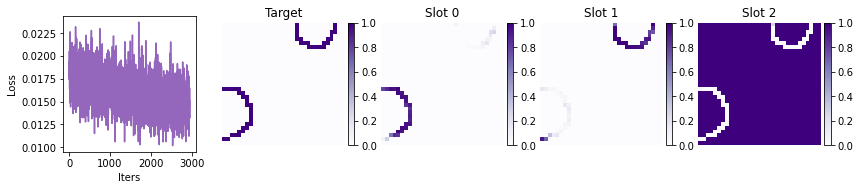

iter 2975 , loss 0.012288676 , lr 0.00015701399900131262


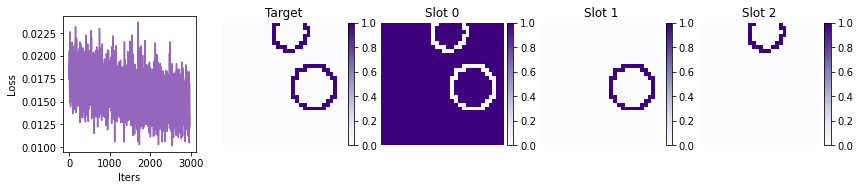

iter 3000 , loss 0.016972307 , lr 0.00015827857968866863


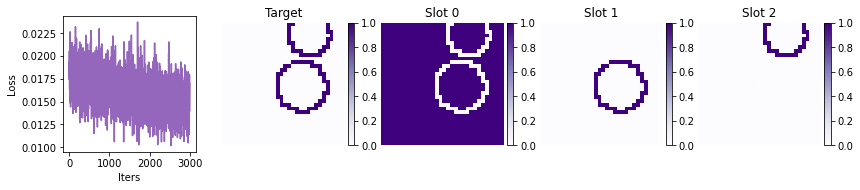

iter 3025 , loss 0.014910809 , lr 0.00015954226513443455


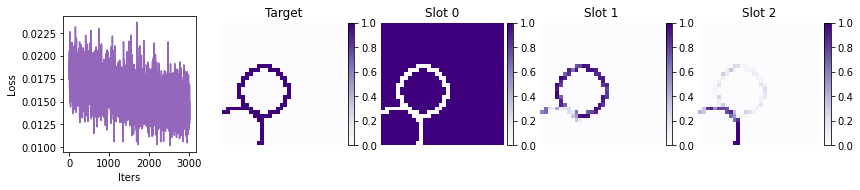

iter 3050 , loss 0.012837166 , lr 0.00016080505580719684


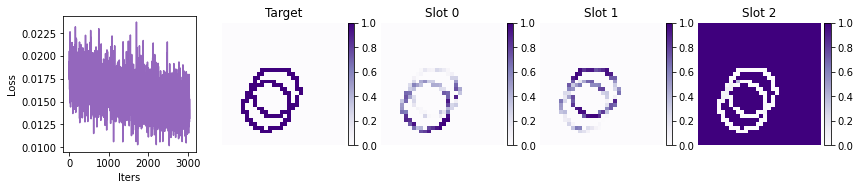

iter 3075 , loss 0.013223783 , lr 0.00016206695217532458


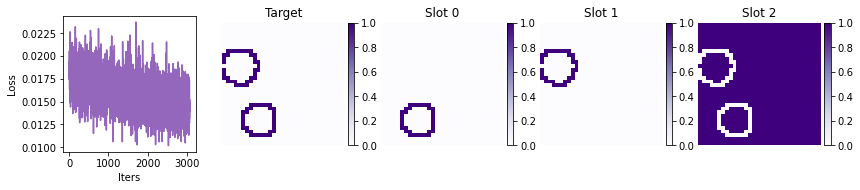

iter 3100 , loss 0.017843612 , lr 0.00016332795470696976


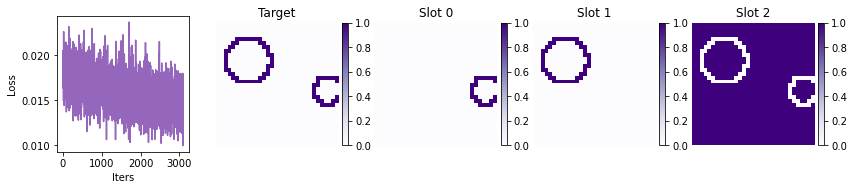

iter 3125 , loss 0.015885398 , lr 0.00016458806387006737


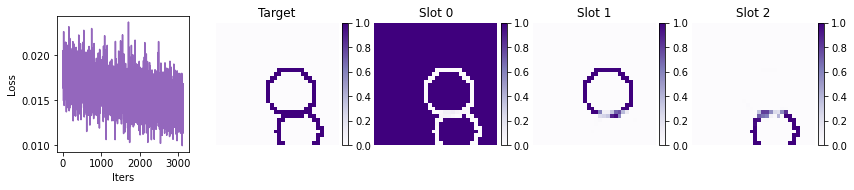

iter 3150 , loss 0.010549097 , lr 0.00016584728013233532


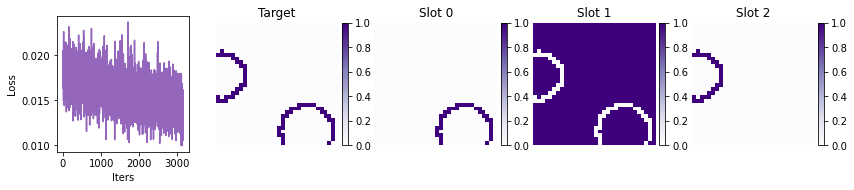

iter 3175 , loss 0.014102125 , lr 0.00016710560396127473


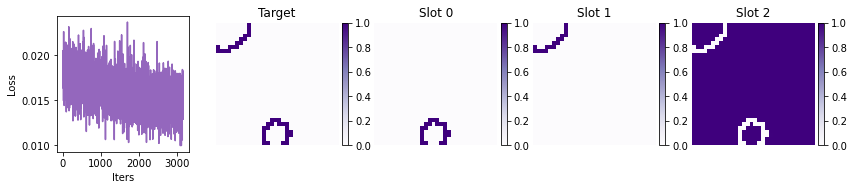

iter 3200 , loss 0.013087136 , lr 0.00016836303582416987


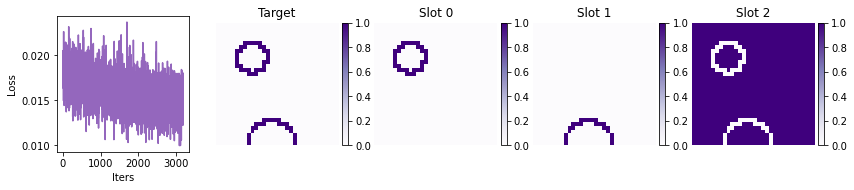

iter 3225 , loss 0.01369537 , lr 0.00016961957618808846


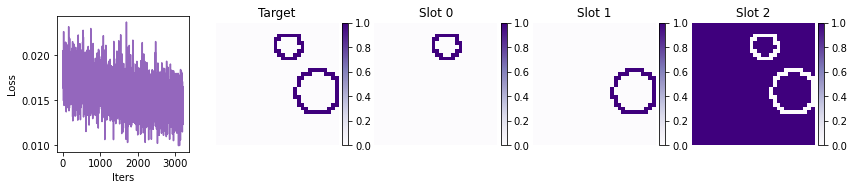

iter 3250 , loss 0.015867112 , lr 0.00017087522551988144


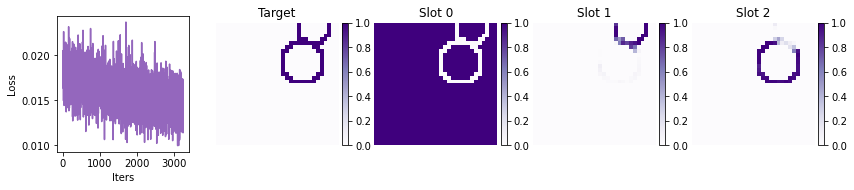

iter 3275 , loss 0.013824234 , lr 0.00017212998428618335


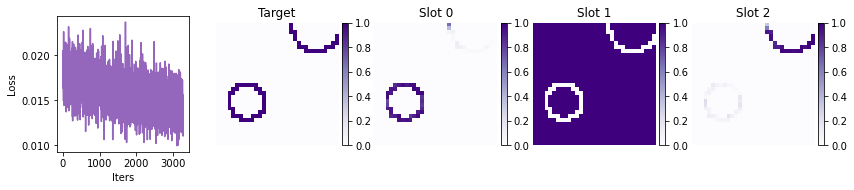

iter 3300 , loss 0.014566086 , lr 0.0001733838529534124


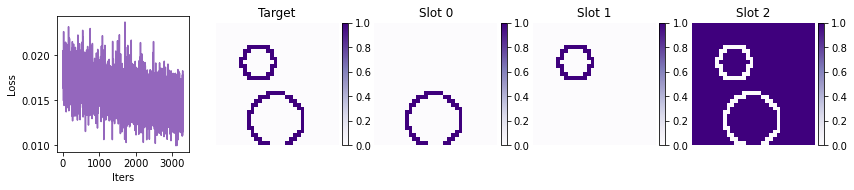

iter 3325 , loss 0.014261985 , lr 0.00017463683198777033


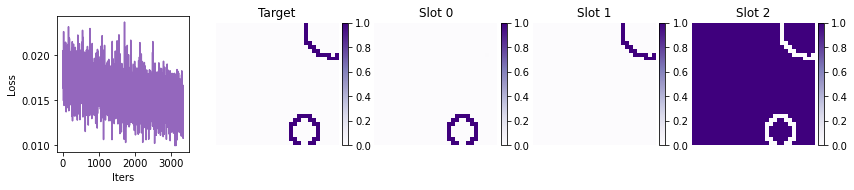

iter 3350 , loss 0.013514839 , lr 0.00017588892185524285


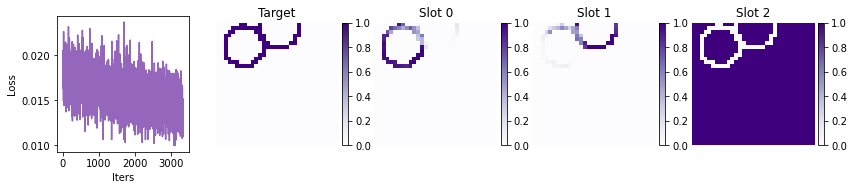

iter 3375 , loss 0.015132437 , lr 0.00017714012302159937


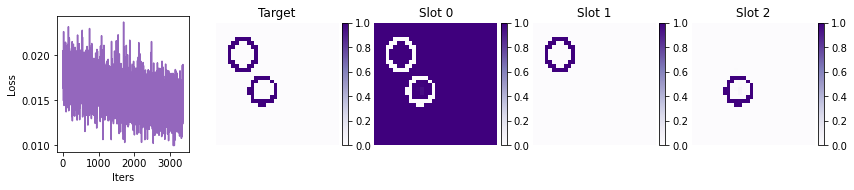

iter 3400 , loss 0.013585447 , lr 0.00017839043595239338


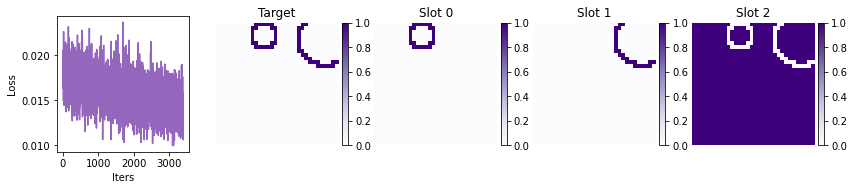

iter 3425 , loss 0.014944545 , lr 0.00017963986111296242


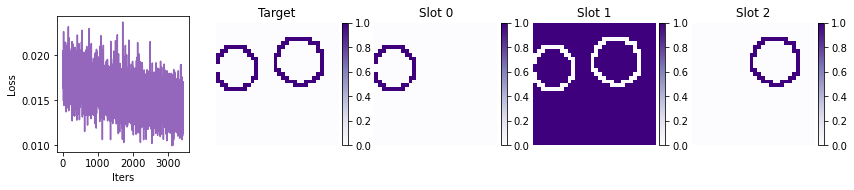

iter 3450 , loss 0.014586758 , lr 0.00018088839896842815


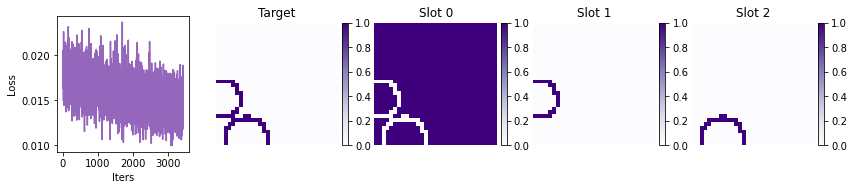

iter 3475 , loss 0.012846929 , lr 0.00018213604998369658


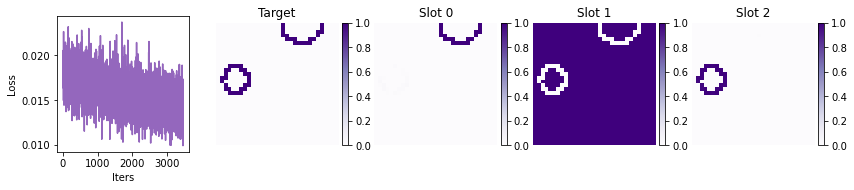

iter 3500 , loss 0.01330884 , lr 0.00018338281462345794


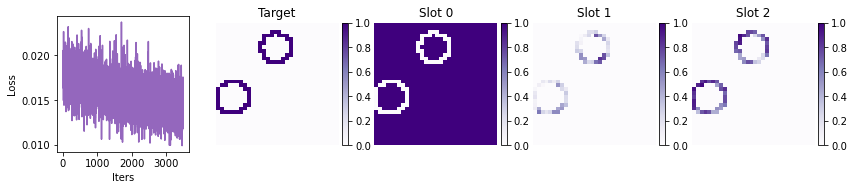

iter 3525 , loss 0.015890729 , lr 0.00018462869335218702


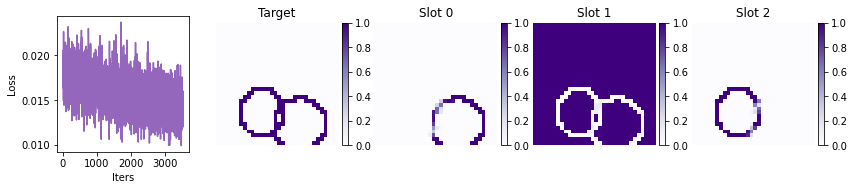

iter 3550 , loss 0.016029485 , lr 0.00018587368663414304


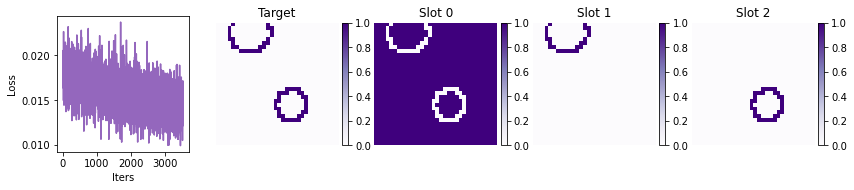

iter 3575 , loss 0.012882282 , lr 0.00018711779493336988


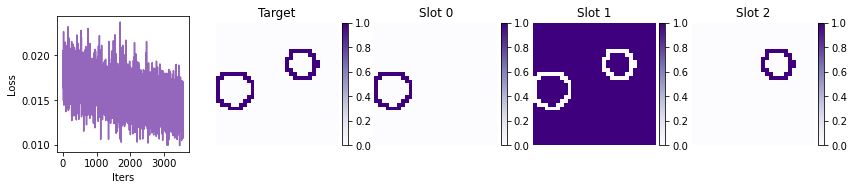

iter 3600 , loss 0.015307041 , lr 0.00018836101871369624


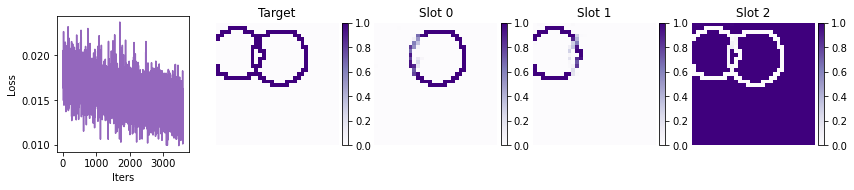

iter 3625 , loss 0.16416644 , lr 0.0001896033584387355


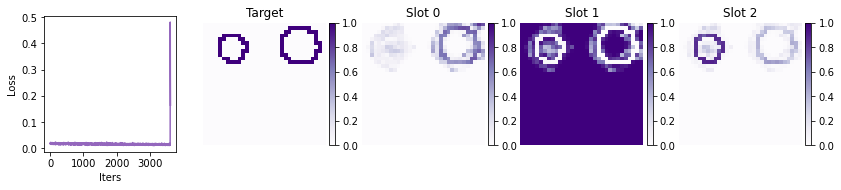

iter 3650 , loss 0.08691499 , lr 0.00019084481457188604


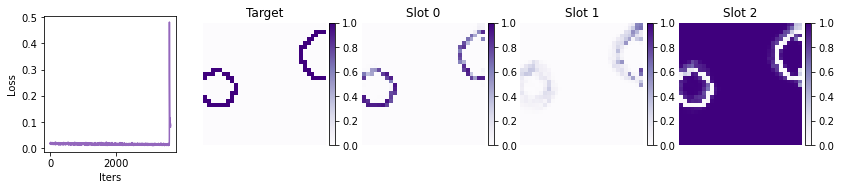

iter 3675 , loss 0.067057535 , lr 0.00019208538757633115


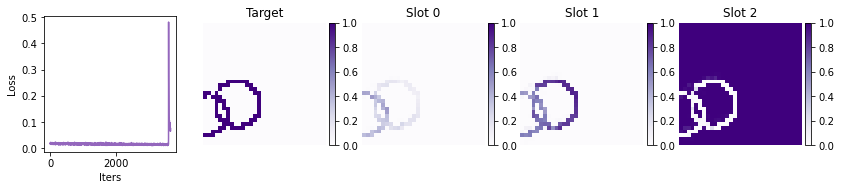

iter 3700 , loss 0.0539347 , lr 0.0001933250779150393


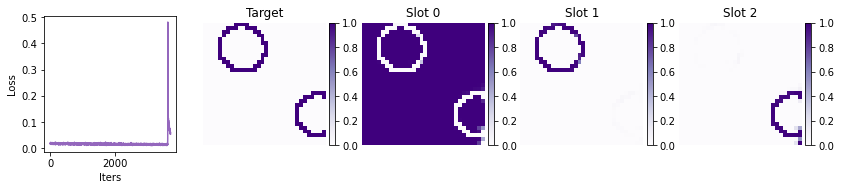

iter 3725 , loss 0.057748728 , lr 0.00019456388605076417


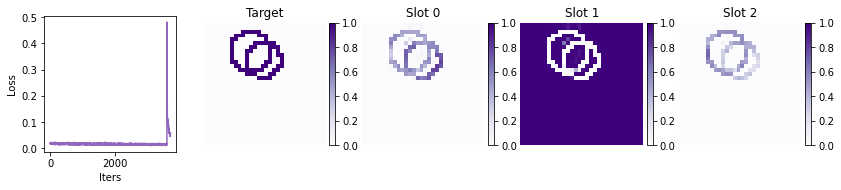

iter 3750 , loss 0.041225366 , lr 0.00019580181244604458


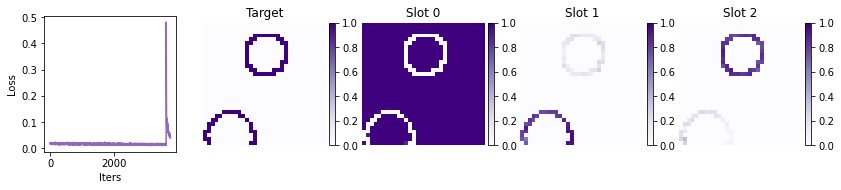

iter 3775 , loss 0.03599219 , lr 0.0001970388575632049


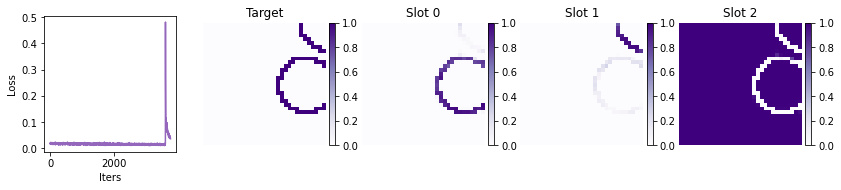

iter 3800 , loss 0.036870934 , lr 0.0001982750218643549


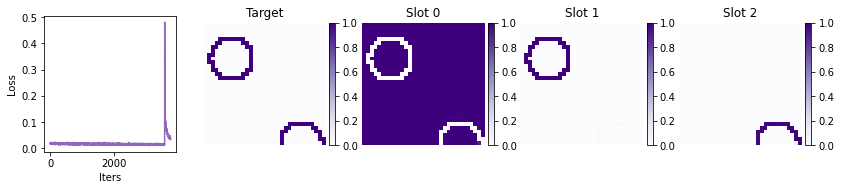

iter 3825 , loss 0.037772 , lr 0.0001995103058113898


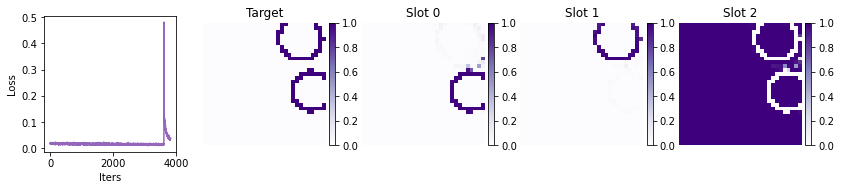

iter 3850 , loss 0.031798992 , lr 0.00020074470986599066


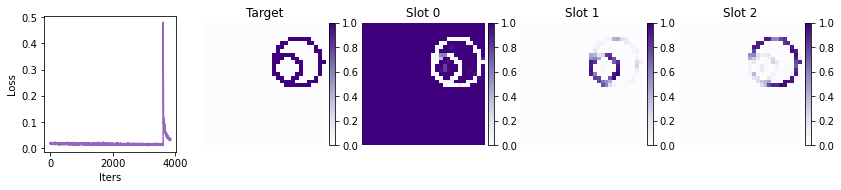

iter 3875 , loss 0.028408796 , lr 0.00020197823448962418


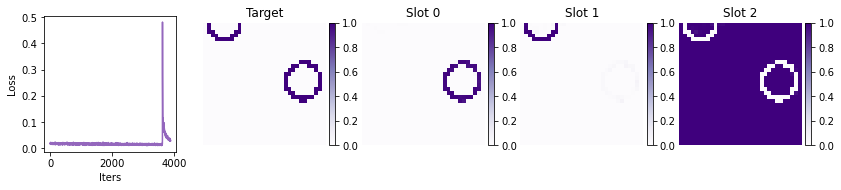

iter 3900 , loss 0.030749232 , lr 0.00020321088014354295


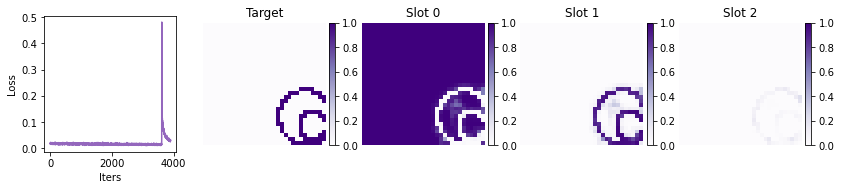

iter 3925 , loss 0.02968489 , lr 0.00020444264728878542


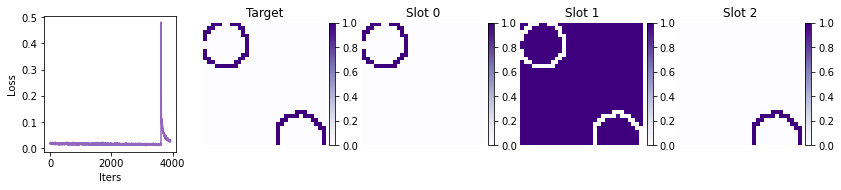

iter 3950 , loss 0.029952515 , lr 0.0002056735363861761


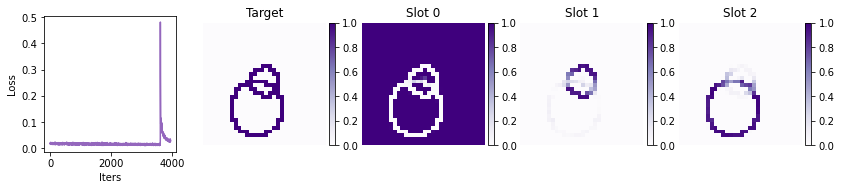

iter 3975 , loss 0.030330963 , lr 0.00020690354789632576


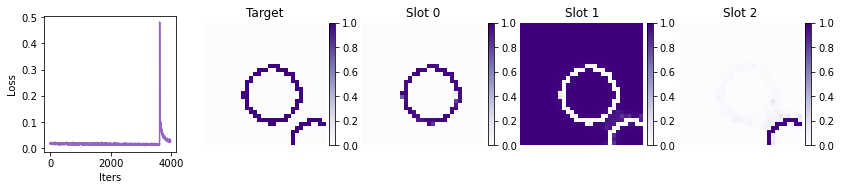

iter 4000 , loss 0.02984853 , lr 0.00020813268227963113


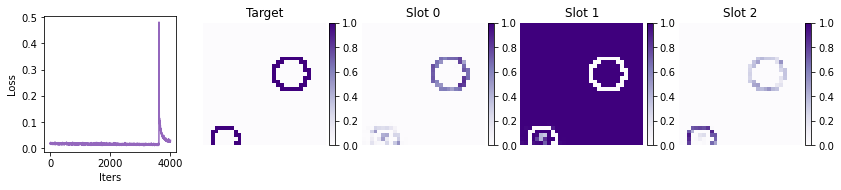

iter 4025 , loss 0.02846139 , lr 0.0002093609399962754


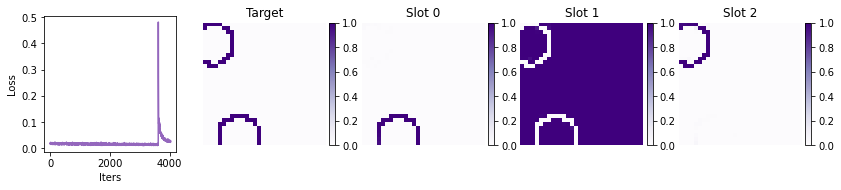

iter 4050 , loss 0.024539642 , lr 0.00021058832150622819


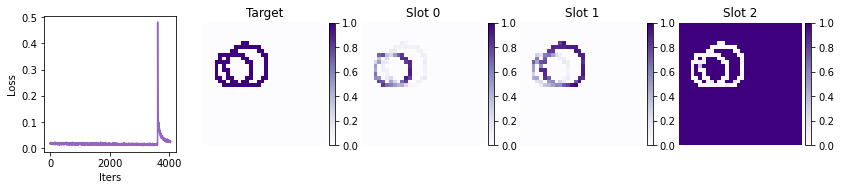

iter 4075 , loss 0.024645092 , lr 0.00021181482726924549


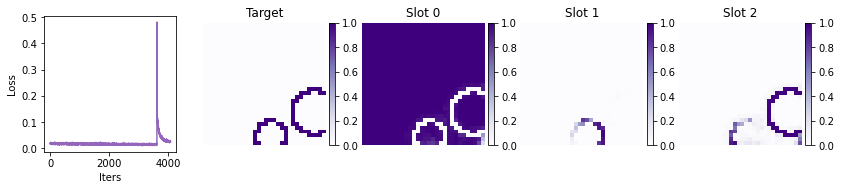

iter 4100 , loss 0.024812076 , lr 0.00021304045774487


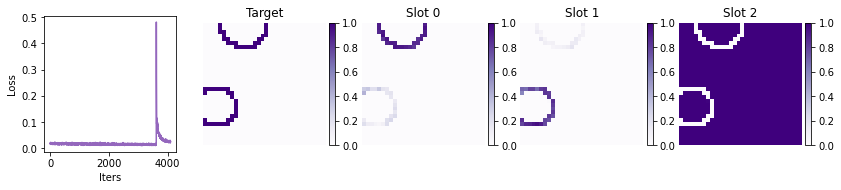

iter 4125 , loss 0.025763627 , lr 0.00021426521339243097


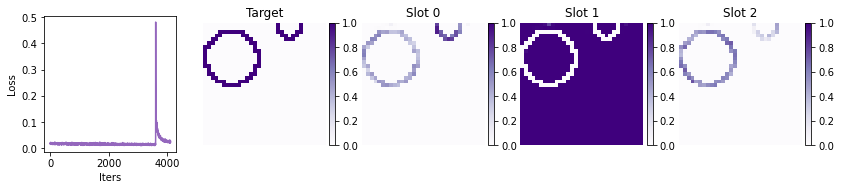

iter 4150 , loss 0.025696963 , lr 0.00021548909467104452


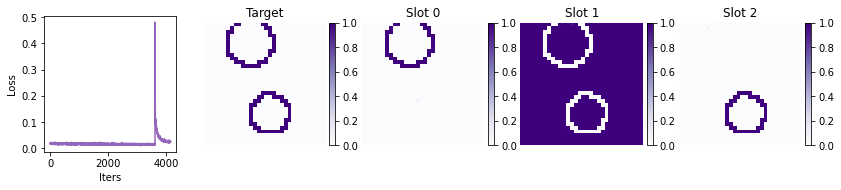

iter 4175 , loss 0.022348922 , lr 0.00021671210203961364


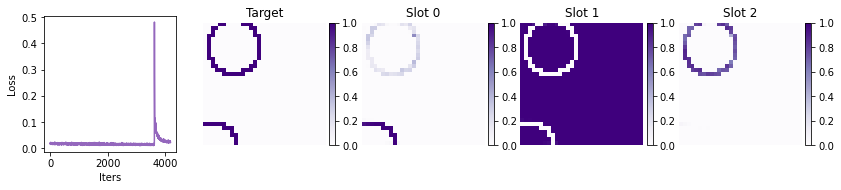

iter 4200 , loss 0.030450724 , lr 0.00021793423595682816


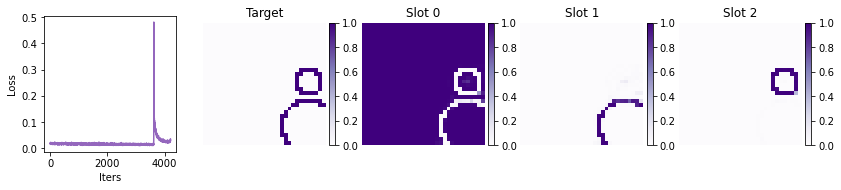

iter 4225 , loss 0.046070218 , lr 0.00021915549688116508


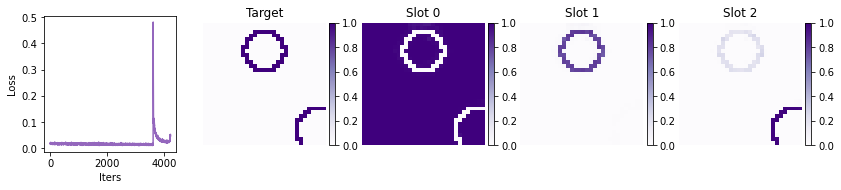

iter 4250 , loss 0.031147277 , lr 0.0002203758852708885


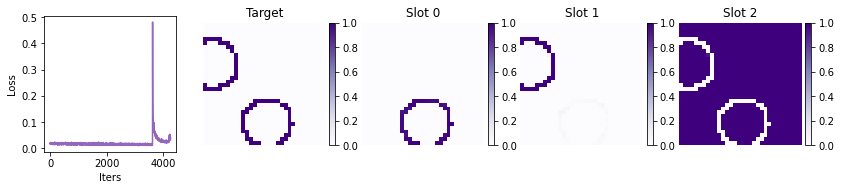

iter 4275 , loss 0.029973006 , lr 0.00022159540158404967


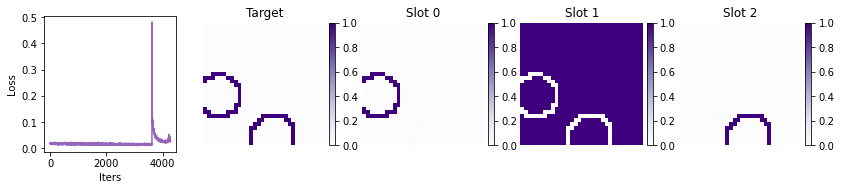

iter 4300 , loss 0.026182957 , lr 0.0002228140462784873


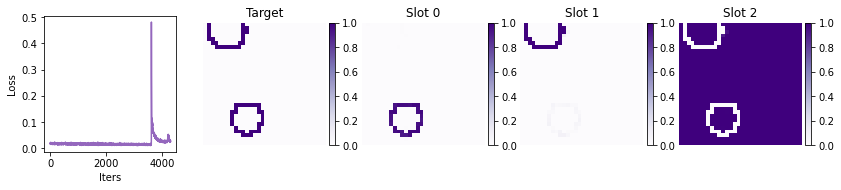

iter 4325 , loss 0.03852211 , lr 0.00022403181981182742


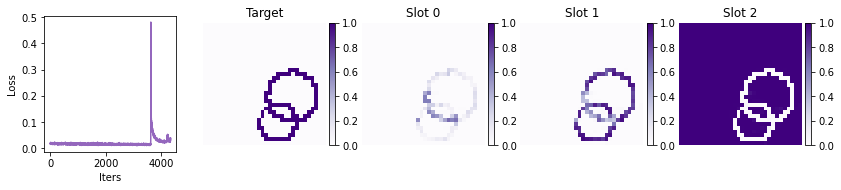

iter 4350 , loss 0.039949264 , lr 0.0002252487226414836


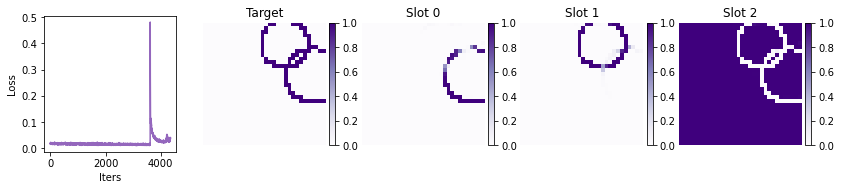

iter 4375 , loss 0.025281172 , lr 0.0002264647552246571


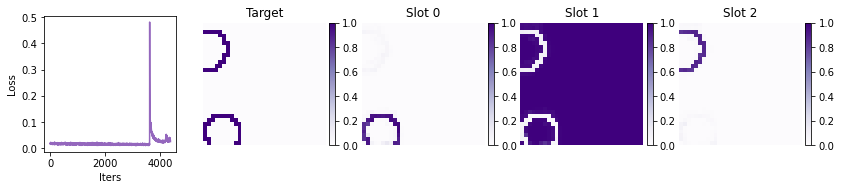

iter 4400 , loss 0.024452392 , lr 0.00022767991801833664


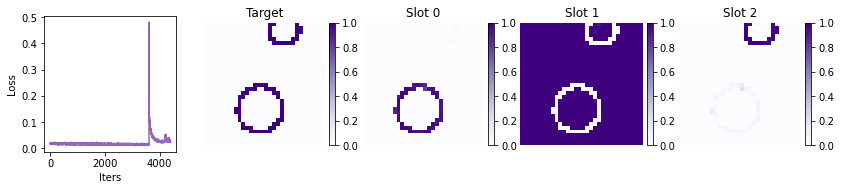

iter 4425 , loss 0.03135929 , lr 0.00022889421147929896


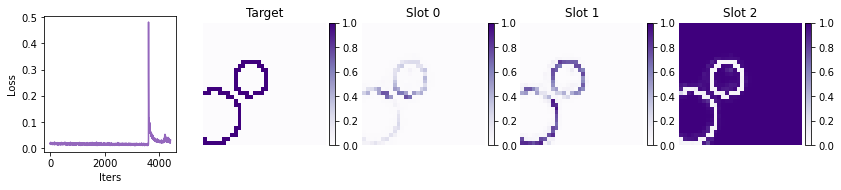

iter 4450 , loss 0.023596931 , lr 0.00023010763606410862


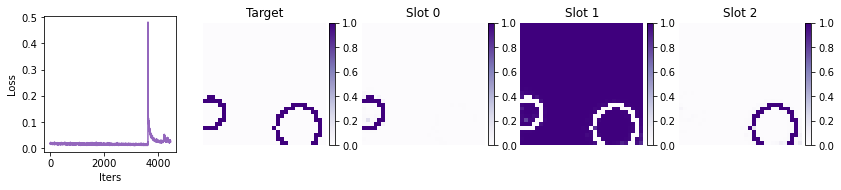

iter 4475 , loss 0.0327453 , lr 0.0002313201922291181


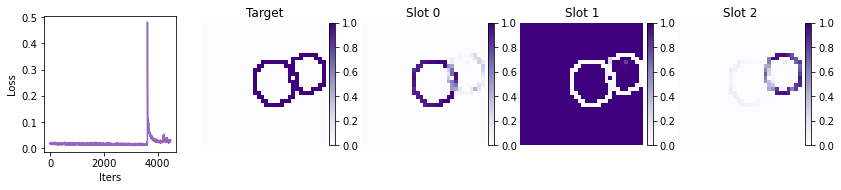

iter 4500 , loss 0.02857461 , lr 0.00023253188043046797


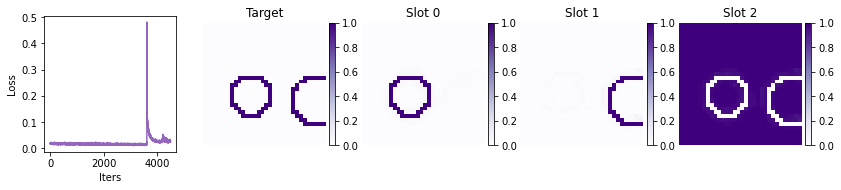

iter 4525 , loss 0.028927736 , lr 0.00023374270112408687


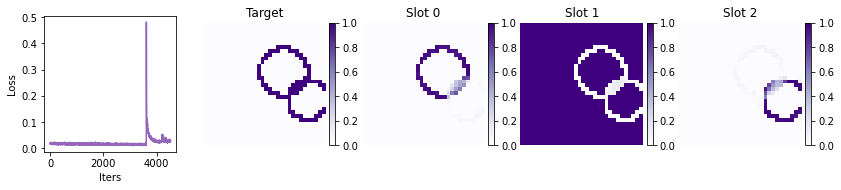

iter 4550 , loss 0.023052692 , lr 0.00023495265476569188


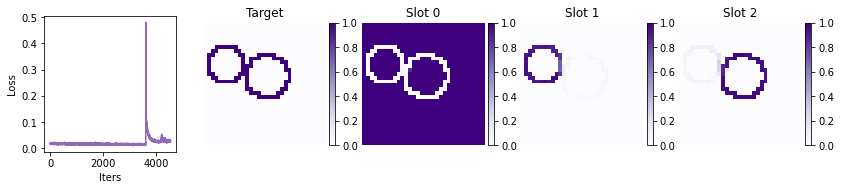

iter 4575 , loss 0.031188263 , lr 0.0002361617418107883


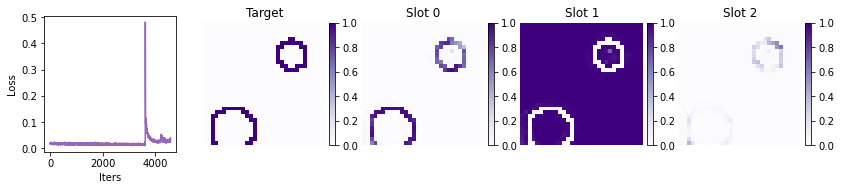

iter 4600 , loss 0.025452206 , lr 0.0002373699627146698


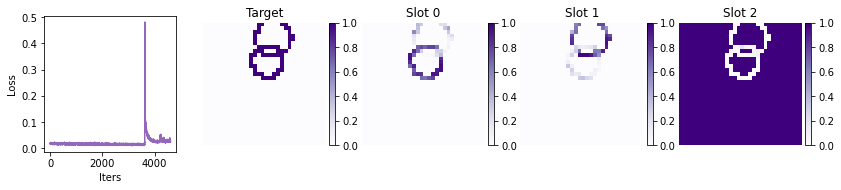

iter 4625 , loss 0.02384453 , lr 0.0002385773179324187


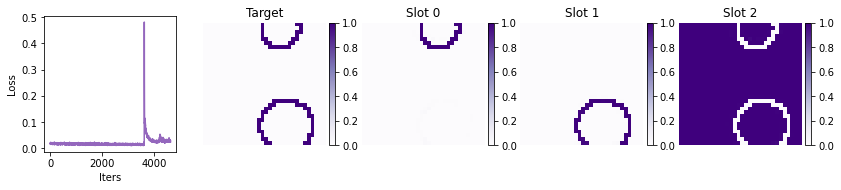

iter 4650 , loss 0.034539167 , lr 0.00023978380791890585


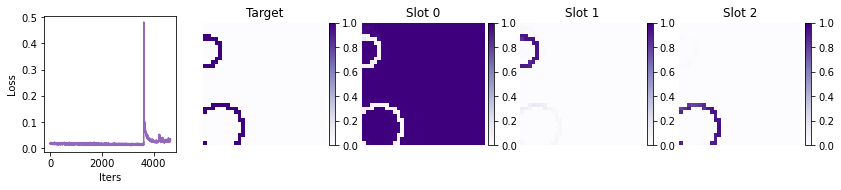

iter 4675 , loss 0.024084894 , lr 0.00024098943312879083


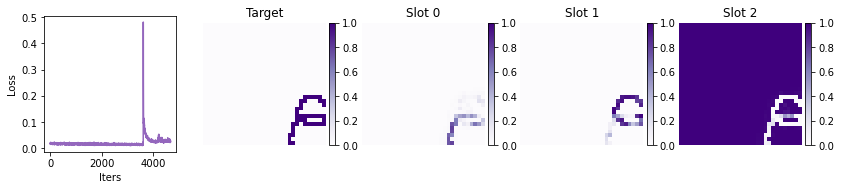

iter 4700 , loss 0.044510383 , lr 0.000242194194016522


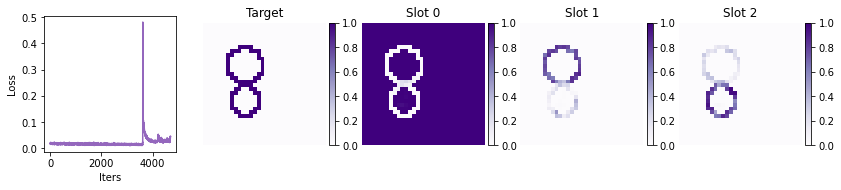

iter 4725 , loss 0.03283653 , lr 0.00024339809103633665


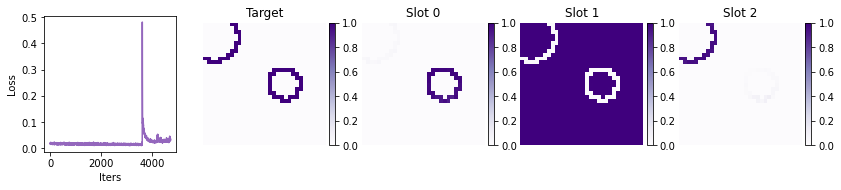

iter 4750 , loss 0.027819501 , lr 0.0002446011246422611


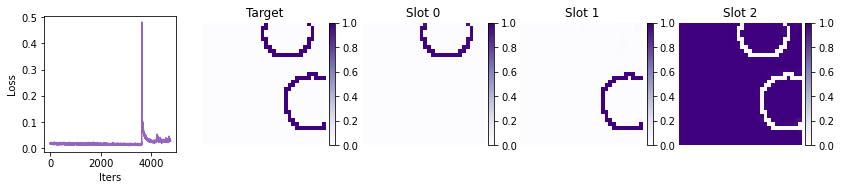

iter 4775 , loss 0.019528382 , lr 0.0002458032952881106


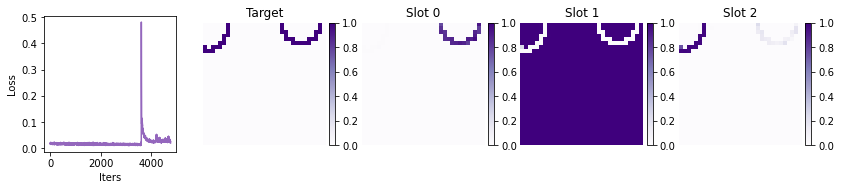

iter 4800 , loss 0.023763165 , lr 0.0002470046034274896


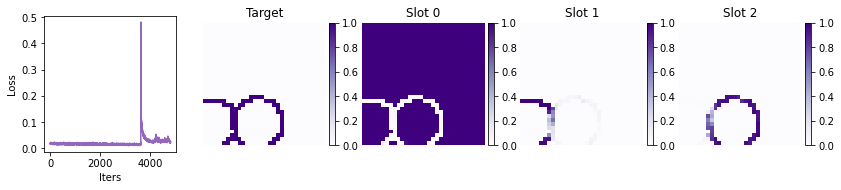

iter 4825 , loss 0.023248706 , lr 0.000248205049513792


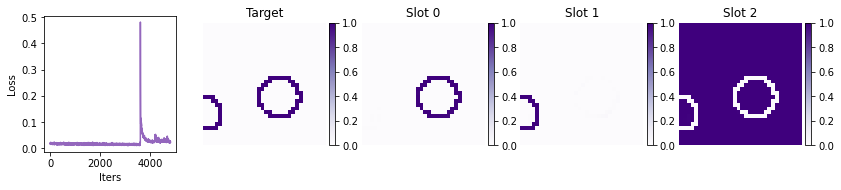

iter 4850 , loss 0.02252302 , lr 0.0002494046340002007


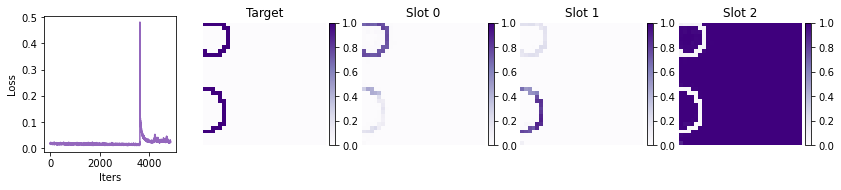

iter 4875 , loss 0.024716951 , lr 0.0002506033573396884


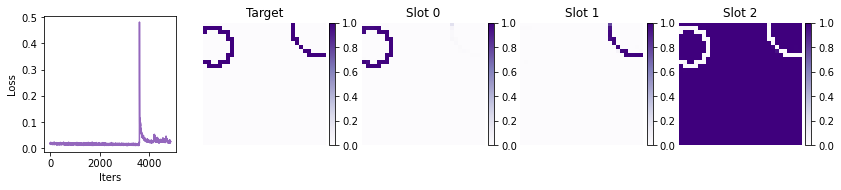

iter 4900 , loss 0.023241866 , lr 0.0002518012199850171


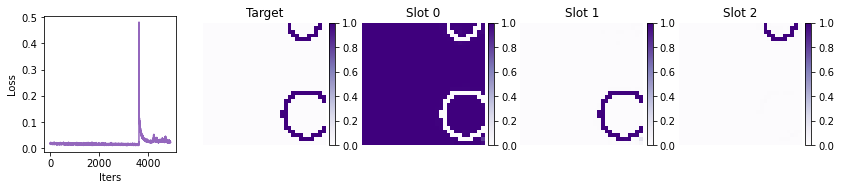

iter 4925 , loss 0.02353986 , lr 0.0002529982223887385


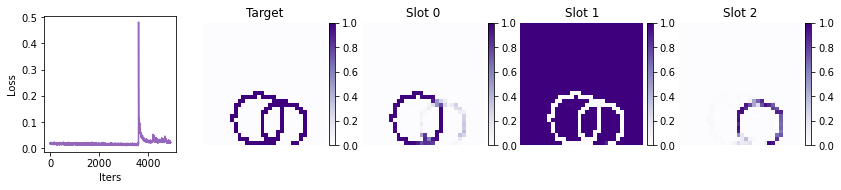

iter 4950 , loss 0.022258997 , lr 0.000254194365003194


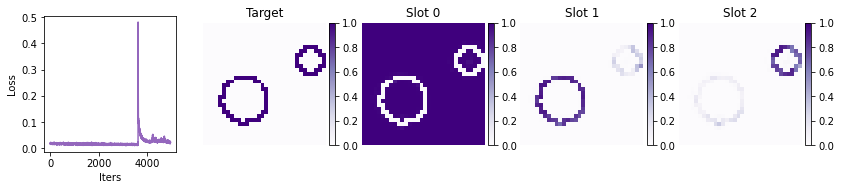

iter 4975 , loss 0.023994416 , lr 0.00025538964828051485


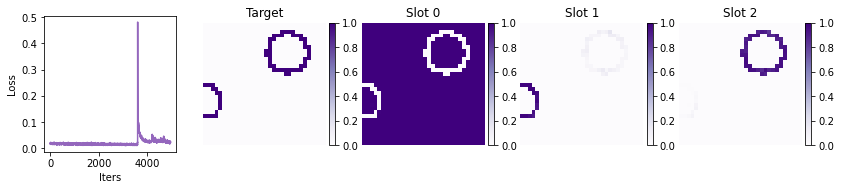

iter 5000 , loss 0.022746986 , lr 0.00025658407267262207


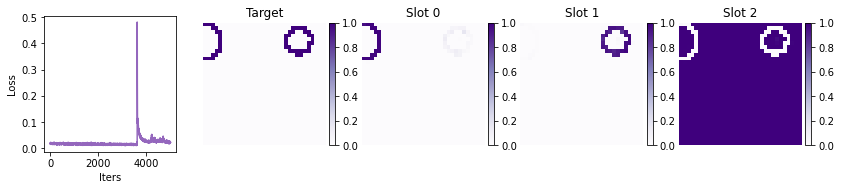

iter 5025 , loss 0.022850202 , lr 0.0002564951628171411


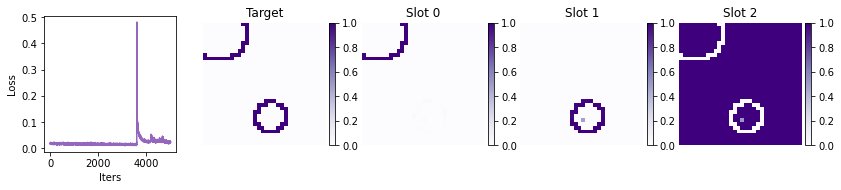

iter 5050 , loss 0.021009732 , lr 0.00025640628377012896


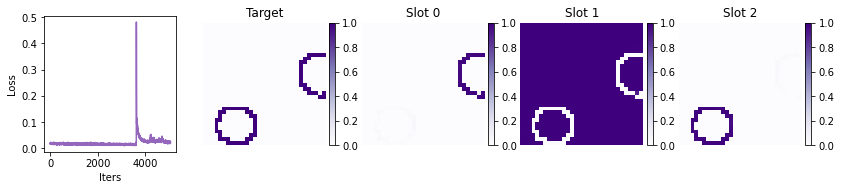

iter 5075 , loss 0.021385118 , lr 0.00025631743552091007


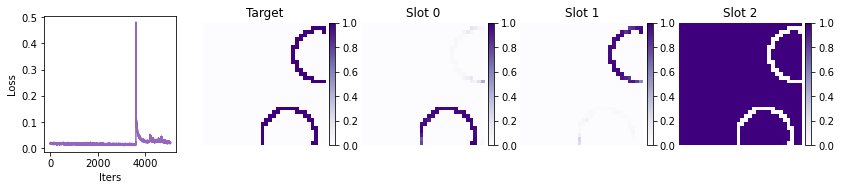

iter 5100 , loss 0.022122495 , lr 0.0002562286180588126


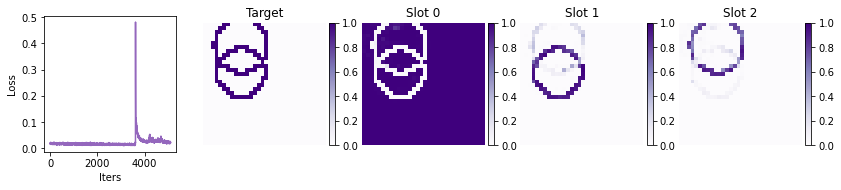

iter 5125 , loss 0.020859318 , lr 0.0002561398313731684


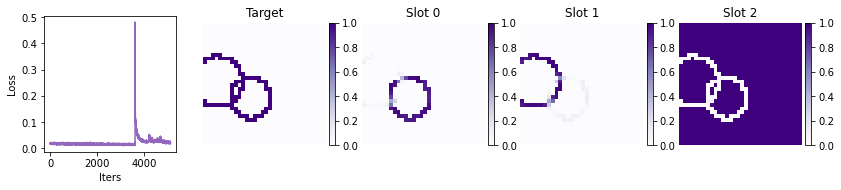

iter 5150 , loss 0.018920884 , lr 0.000256051075453313


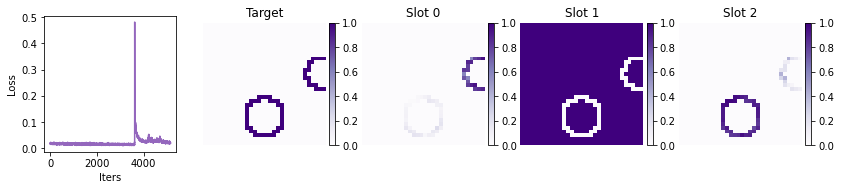

iter 5175 , loss 0.01689553 , lr 0.0002559623502885856


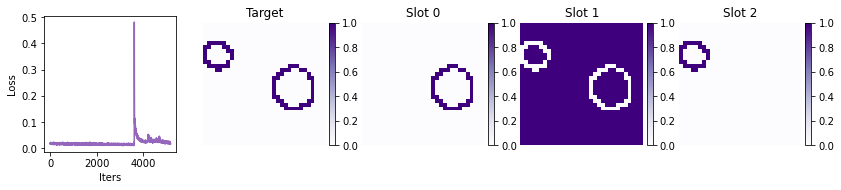

iter 5200 , loss 0.019810356 , lr 0.00025587365586832926


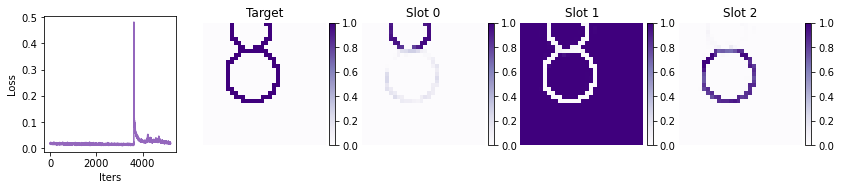

iter 5225 , loss 0.020648539 , lr 0.0002557849921818904


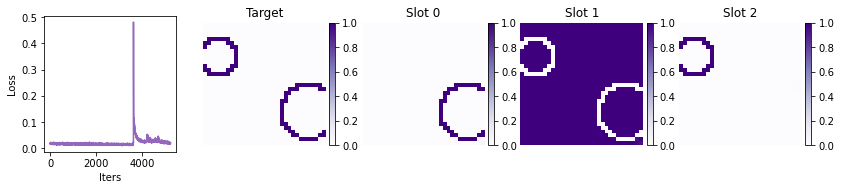

iter 5250 , loss 0.01963409 , lr 0.0002556963592186195


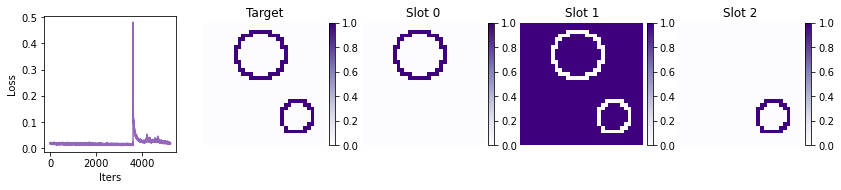

iter 5275 , loss 0.019596882 , lr 0.0002556077569678706


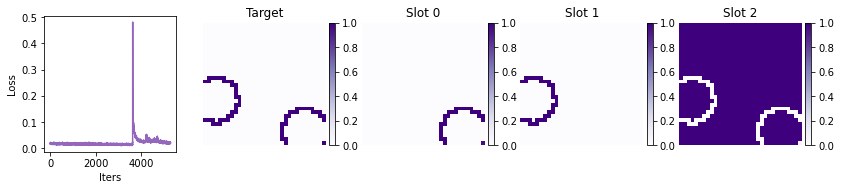

iter 5300 , loss 0.022070207 , lr 0.0002555191854190012


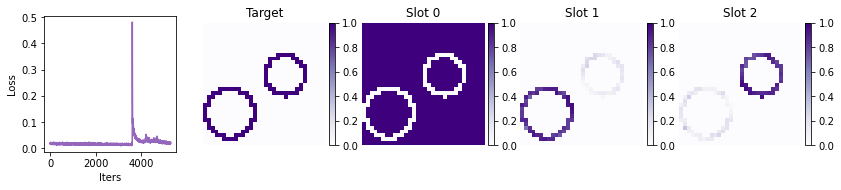

iter 5325 , loss 0.017888073 , lr 0.0002554306445613728


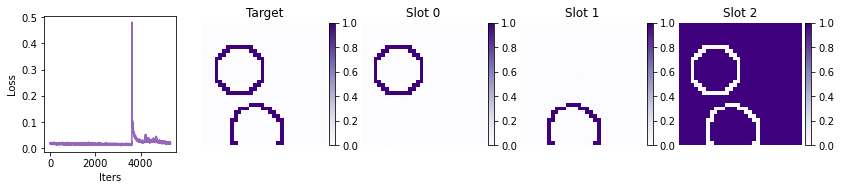

iter 5350 , loss 0.021382703 , lr 0.00025534213438435047


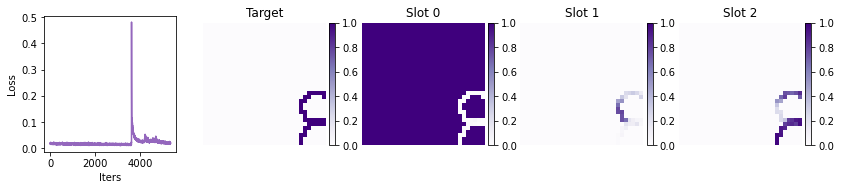

iter 5375 , loss 0.017238945 , lr 0.000255253654877303


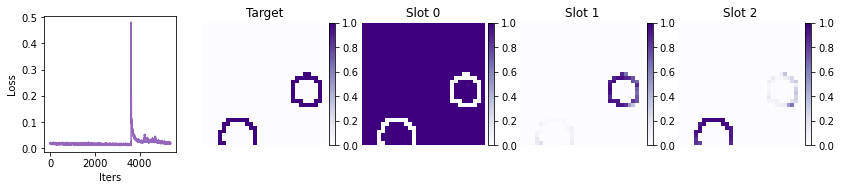

iter 5400 , loss 0.01737653 , lr 0.00025516520602960274


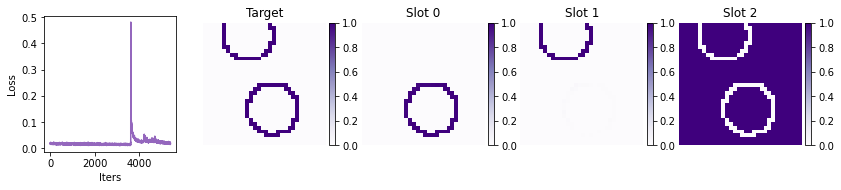

iter 5425 , loss 0.01696258 , lr 0.0002550767878306259


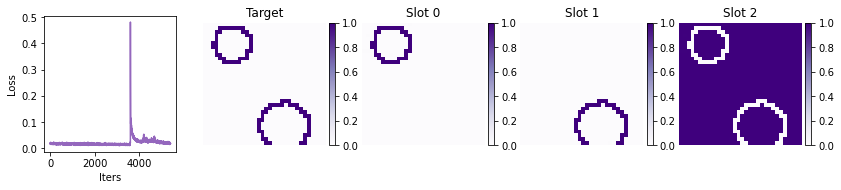

iter 5450 , loss 0.018275924 , lr 0.00025498840026975223


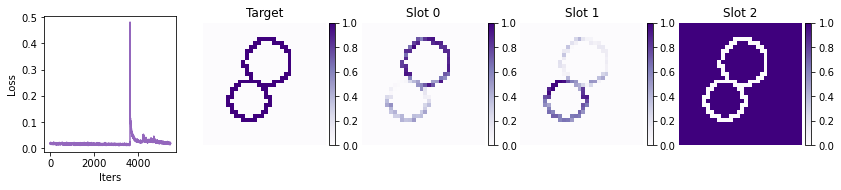

iter 5475 , loss 0.022000697 , lr 0.0002549000433363652


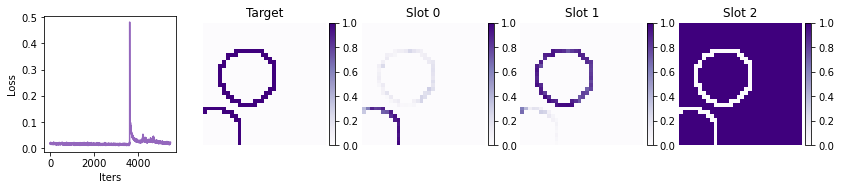

iter 5500 , loss 0.02094588 , lr 0.000254811717019852


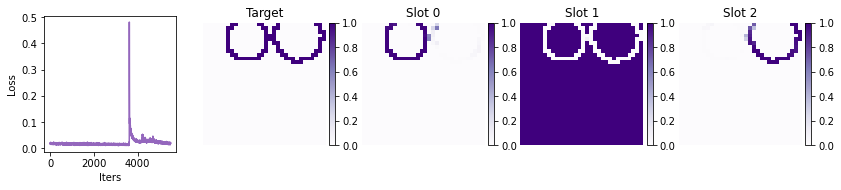

iter 5525 , loss 0.016864913 , lr 0.00025472342130960346


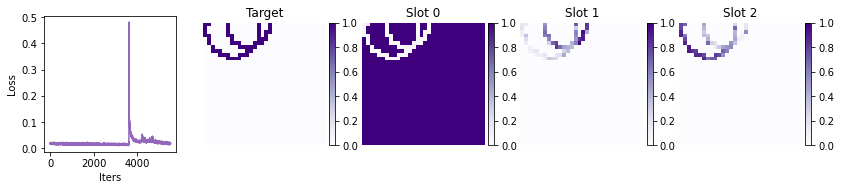

iter 5550 , loss 0.019953426 , lr 0.00025463515619501413


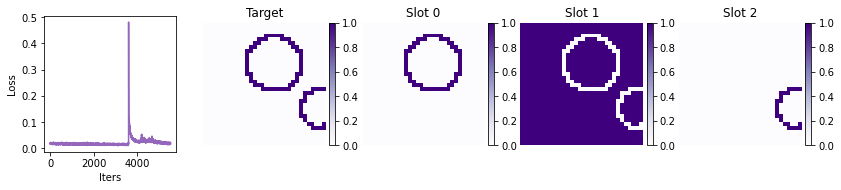

iter 5575 , loss 0.017808044 , lr 0.00025454692166548213


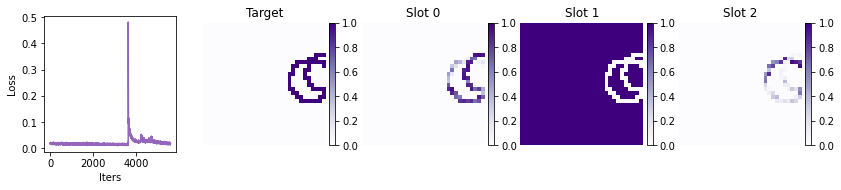

iter 5600 , loss 0.017725145 , lr 0.0002544587177104094


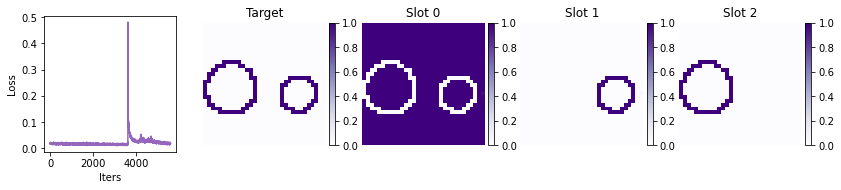

iter 5625 , loss 0.019052444 , lr 0.0002543705443192014


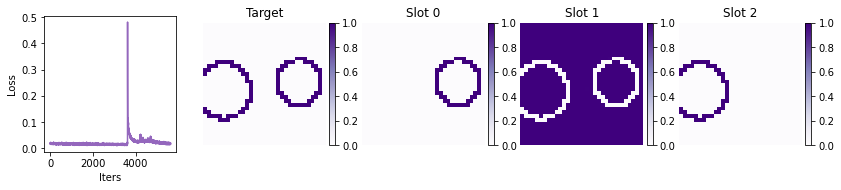

iter 5650 , loss 0.017904192 , lr 0.0002542824014812674


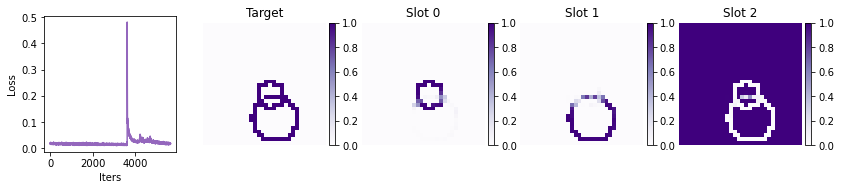

iter 5675 , loss 0.01573532 , lr 0.0002541942891860202


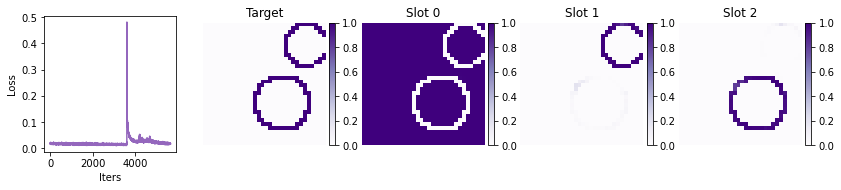

iter 5700 , loss 0.016905876 , lr 0.00025410620742287644


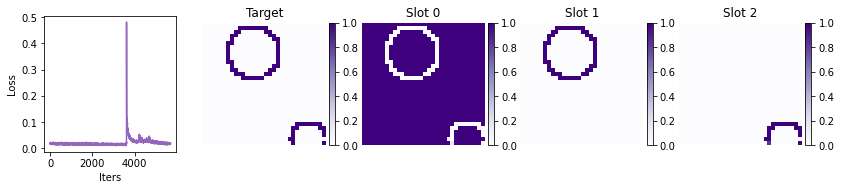

iter 5725 , loss 0.01590887 , lr 0.0002540181561812563


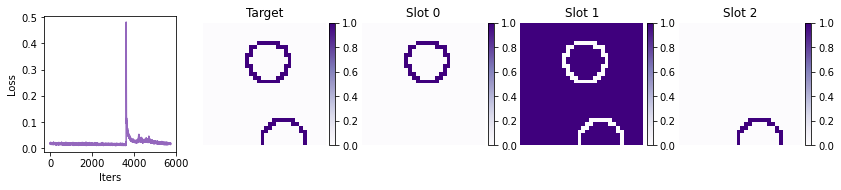

iter 5750 , loss 0.019818515 , lr 0.0002539301354505836


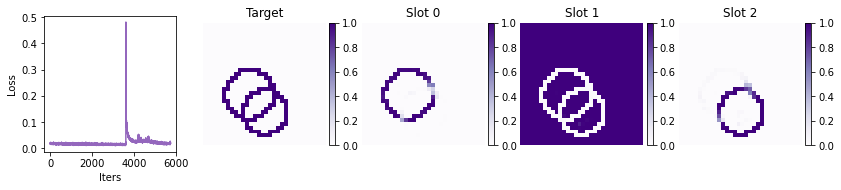

iter 5775 , loss 0.10445302 , lr 0.00025384214522028594


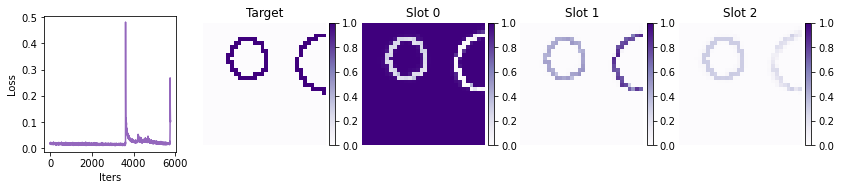

iter 5800 , loss 0.06753351 , lr 0.0002537541854797945


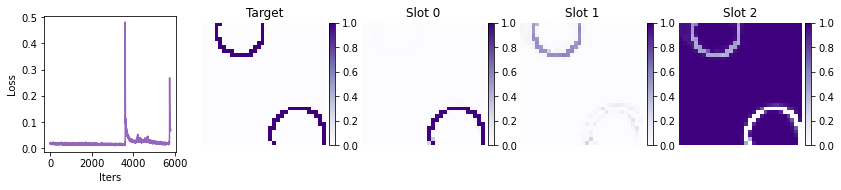

iter 5825 , loss 0.04831295 , lr 0.00025366625621854426


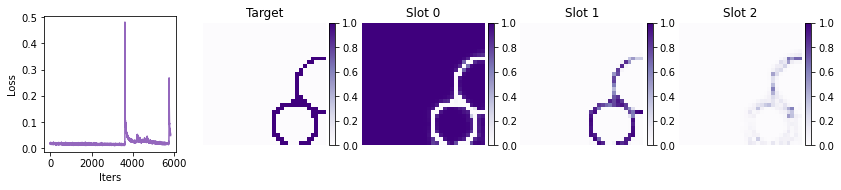

iter 5850 , loss 0.04867523 , lr 0.0002535783574259736


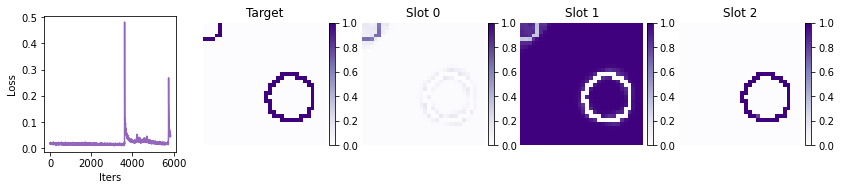

iter 5875 , loss 0.04548066 , lr 0.00025349048909152475


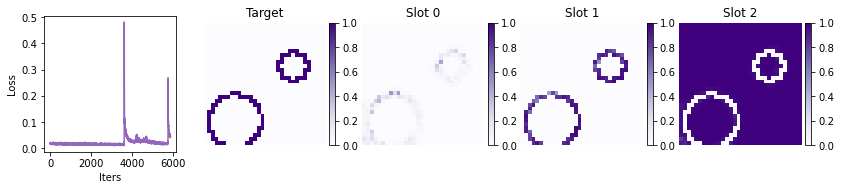

iter 5900 , loss 0.038759366 , lr 0.0002534026512046436


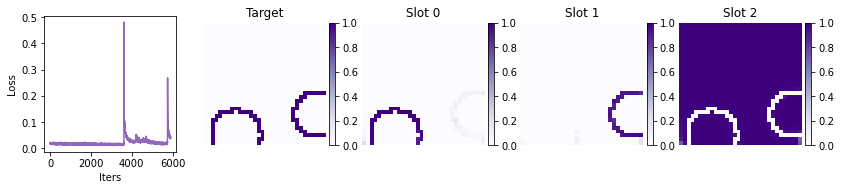

iter 5925 , loss 0.03520494 , lr 0.0002533148437547796


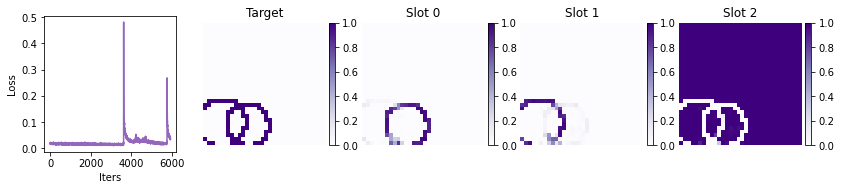

iter 5950 , loss 0.035020985 , lr 0.000253227066731386


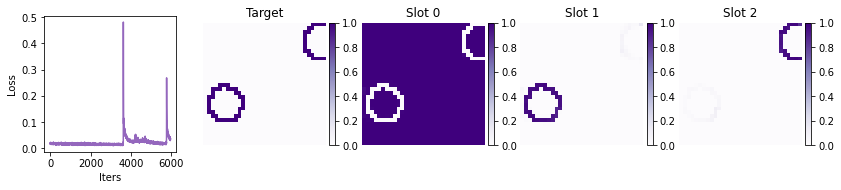

iter 5975 , loss 0.031815227 , lr 0.0002531393201239195


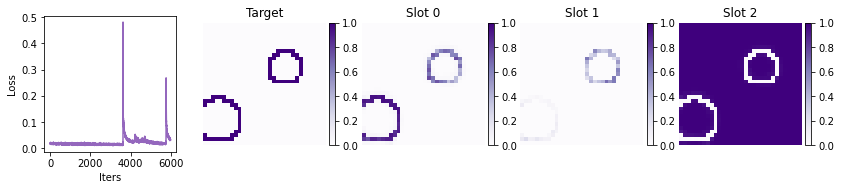

iter 6000 , loss 0.0317085 , lr 0.00025305160392184066


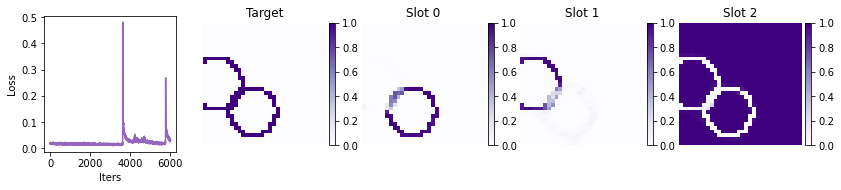

iter 6025 , loss 0.030472424 , lr 0.00025296391811461356


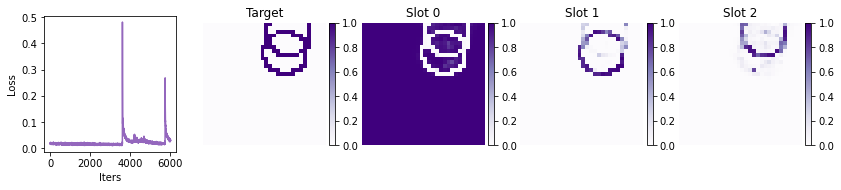

iter 6050 , loss 0.03238187 , lr 0.000252876262691706


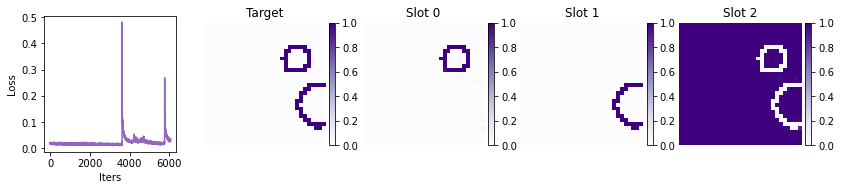

iter 6075 , loss 0.027005143 , lr 0.00025278863764258933


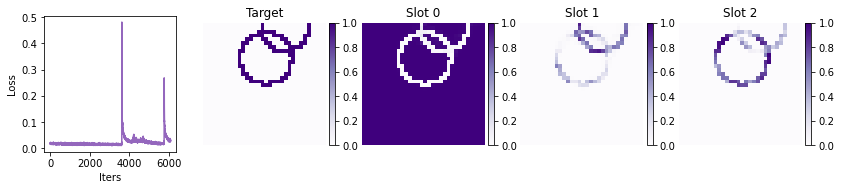

iter 6100 , loss 0.02557266 , lr 0.00025270104295673873


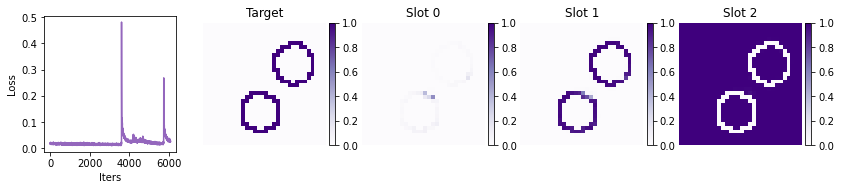

iter 6125 , loss 0.025867268 , lr 0.00025261347862363286


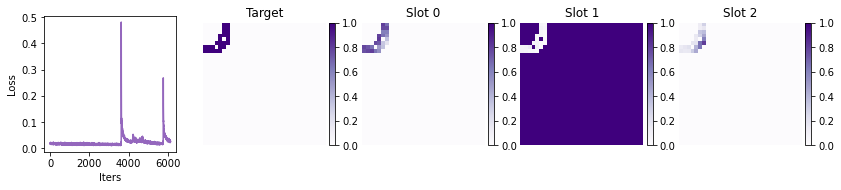

iter 6150 , loss 0.028466055 , lr 0.00025252594463275404


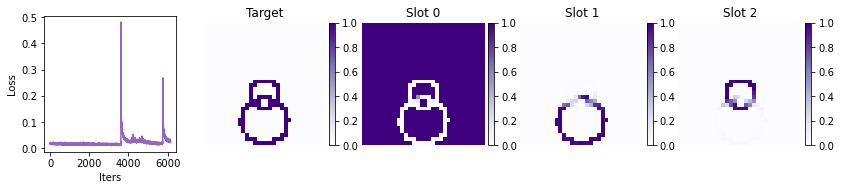

iter 6175 , loss 0.026295025 , lr 0.00025243844097358833


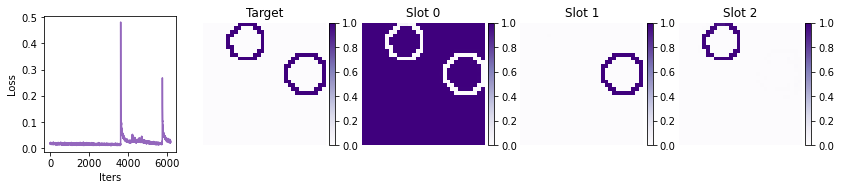

iter 6200 , loss 0.025465501 , lr 0.0002523509676356254


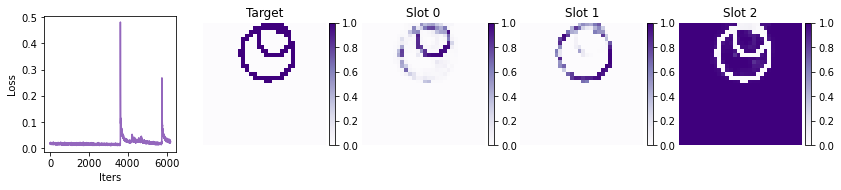

iter 6225 , loss 0.020754052 , lr 0.0002522635246083585


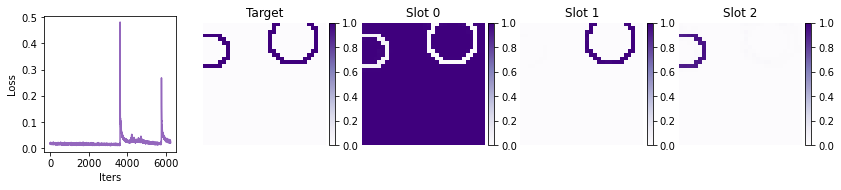

iter 6250 , loss 0.022315588 , lr 0.0002521761118812846


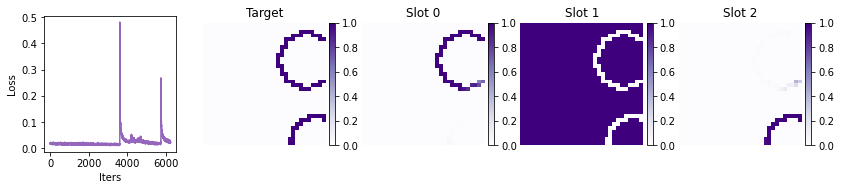

iter 6275 , loss 0.022141207 , lr 0.00025208872944390424


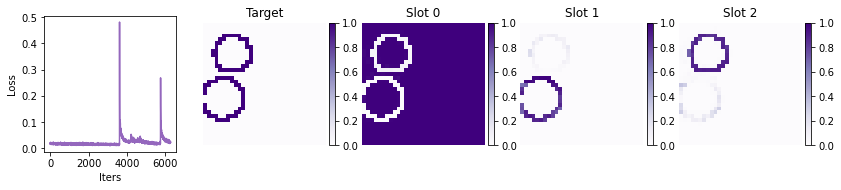

iter 6300 , loss 0.026273558 , lr 0.0002520013772857216


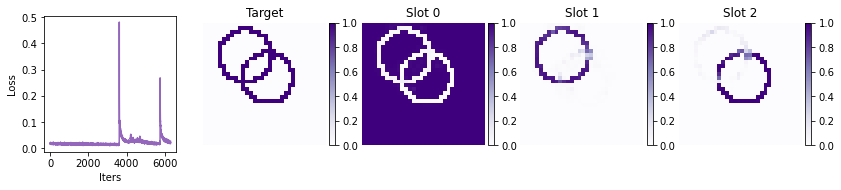

iter 6325 , loss 0.02132805 , lr 0.00025191405539624467


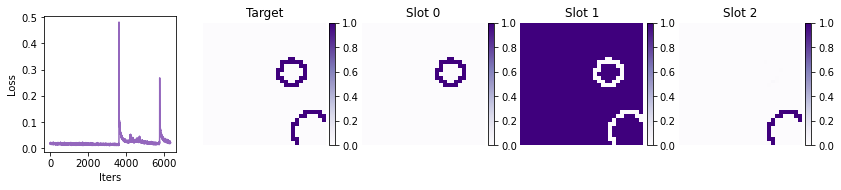

iter 6350 , loss 0.019378204 , lr 0.0002518267637649847


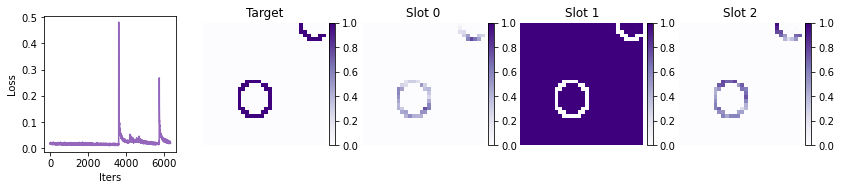

iter 6375 , loss 0.024671601 , lr 0.0002517395023814571


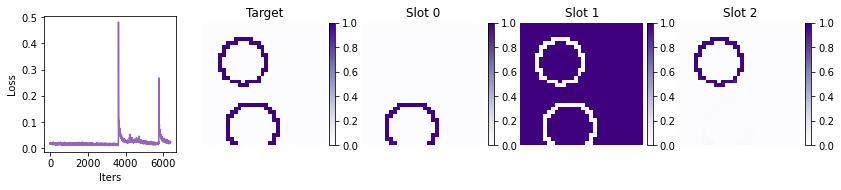

In [ ]:
train(m,kwargs=kwargs,**opt,color='C4',cmap='Purples',device=device,
      modelDir=modelDir,figDir=figDir,plot_every=25,save_every=200)

**TO DO** Add a flag to save the model if I made a really big jump like that

I'm guessing I could ameliorate it by grad clipping

But would need to check

In [27]:
cID
pID = 'li-warm-parallel-10x'

with open(f'code/models/{cID}/loss.json') as f:
    ld = pd.Series(json.load(f))

with open(f'code/models/{pID}/loss.json') as f:
    lp = pd.Series(json.load(f))


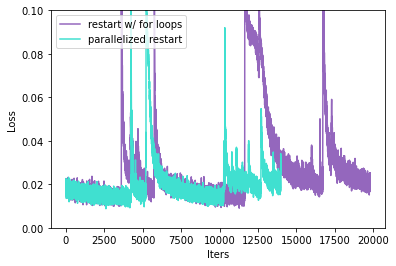

In [37]:
roll_avg=1
plt.plot(ld.rolling(roll_avg).mean()[roll_avg:],
         color='C4',label='restart w/ for loops')
plt.plot(lp.rolling(roll_avg).mean()[roll_avg:],
         color='turquoise',label='parallelized restart')
plt.ylim(0,.1)
plt.legend()
plt.xlabel('Iters')
plt.ylabel('Loss')

plt.show()

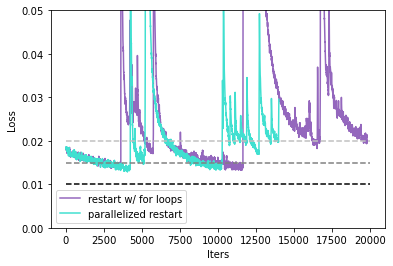

In [34]:
roll_avg=20
plt.plot(ld.rolling(roll_avg).mean()[roll_avg:],
         color='C4',label='restart w/ for loops')
plt.plot(lp.rolling(roll_avg).mean()[roll_avg:],
         color='turquoise',label='parallelized restart')
plt.ylim(0,.05)
plt.legend()
plt.xlabel('Iters')
plt.ylabel('Loss')

plt.plot([0,20_000],[.02]*2,color='silver',ls='--')
plt.plot([0,20_000],[.015]*2,color='grey',ls='--')
plt.plot([0,20_000],[.01]*2,'k--')
plt.show()

OK... let's quantify how to find these jumps!

Text(0, 0.5, 'Current loss / Previous loss_')

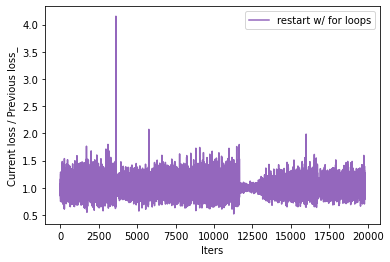

In [38]:
plt.plot(ld[1:].values/ld[:-1].values,
         color='C4',label='restart w/ for loops')
# plt.plot(lp[1:].values/lp[:-1].values,
#          color='turquoise',label='parallelized restart')



plt.legend()
plt.xlabel('Iters')
plt.ylabel('Current loss / Previous loss_')

Text(0, 0.5, 'Current loss / Previous loss')

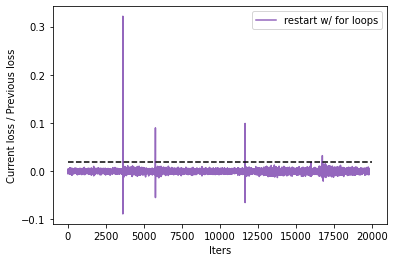

In [52]:
plt.plot(np.diff(ld.values),
         color='C4',label='restart w/ for loops')
# plt.plot(lp[1:].values/lp[:-1].values,
#          color='turquoise',label='parallelized restart')

plt.plot([0,20_000],[.02]*2,'k--')
plt.legend()
plt.xlabel('Iters')
plt.ylabel('Current loss / Previous loss')

# plt.xlim(5750,5760)

(5750.0, 5760.0)

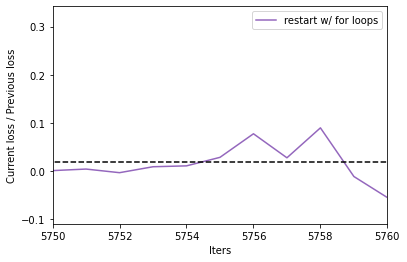

In [51]:
plt.plot(np.diff(ld.values),
         color='C4',label='restart w/ for loops')
# plt.plot(lp[1:].values/lp[:-1].values,
#          color='turquoise',label='parallelized restart')

plt.plot([0,20_000],[.02]*2,'k--')
plt.legend()
plt.xlabel('Iters')
plt.ylabel('Current loss / Previous loss')

plt.xlim(5750,5760)

In [47]:
i_jump = np.diff(ld.values) > .02

In [48]:
np.arange(len(i_jump))[i_jump]

array([ 3616,  3617,  5755,  5756,  5757,  5758, 11639, 11640, 11649,
       11650, 11651, 16723, 16727])

- I expect at least 4 (maybe 5) "jumps"

**Ideas:**
- Could c.f. an average of the last 100 events?

Text(0, 0.5, 'Current loss / Previous loss')

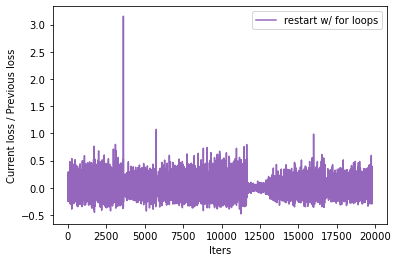

In [39]:
plt.plot( (ld[1:].values - ld[:-1].values ) / ld[:-1].values,
         color='C4',label='restart w/ for loops')
# plt.plot(lp[1:].values/lp[:-1].values,
#          color='turquoise',label='parallelized restart')

plt.legend()
plt.xlabel('Iters')
plt.ylabel('Current loss / Previous loss')